Status: complete

Potential future work:
- Re-perform some analysis after performing error correction (allowing one round to be different)
- Better PCR duplication rate estimation

# Setup

In [1]:
%load_ext autoreload
%autoreload 2
%load_ext watermark

In [ ]:
import collections
import gzip
import itertools
import json
import os
import re
import subprocess
import sys
import numpy as np
import scipy
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.auto import tqdm

sys.path.append('../scripts')
import string_distances
import helpers
import plot_features

In [ ]:
%watermark
%watermark --conda
%watermark --iversions

In [4]:
DIR_PROJECT = '/central/groups/guttman/btyeh/scBarcode'
DIR_DATA = os.path.join(DIR_PROJECT, 'data', '20231017')
DIR_PROC = os.path.join(DIR_PROJECT, 'data_proc', '20231017')
DIR_AUX = os.path.join(DIR_PROJECT, 'data_aux', '20231017')
DIR_RESULTS = os.path.join(DIR_PROJECT, 'results', '20231017')

os.makedirs(DIR_AUX, exist_ok=True)
os.makedirs(DIR_PROC, exist_ok=True)
os.makedirs(DIR_RESULTS, exist_ok=True)

# Constants and Helpers

In [5]:
ROUNDS = ['R1', 'R2', 'R3', 'NYLigOdd']

In [6]:
dict_complement = {'A': 'T', 'T': 'A', 'C': 'G', 'G': 'C', 'N': 'N'}
def reverse_complement(s, allow_noncanonical=False):
    if allow_noncanonical is False:
        return ''.join(dict_complement[base] for base in reversed(s))
    else:
        return ''.join(dict_complement.get(base, base) for base in reversed(s))

# Data

- [Enhanced Sample Sheet](https://docs.google.com/spreadsheets/d/1WnPPy8sIjEyHyDYlc-2d4FZv5S3bswzI-nVnJIN1-j4/)
- [Library sheet](https://docs.google.com/spreadsheets/d/1L6ApxFhI4sA849qRKCQCqkCC95QYi7VpuBzUEH4aPZ4/)
- [Benchling notebook](https://benchling.com/s/etr-5fnlp2r3TvdgBXmWeyxQ)

In [7]:
regex_fastq_files = re.compile((
    r'(?P<filename>BTY_scBarcode_(?P<sample>[A-Z]\d+)_.*R(?P<read>1|2)_001.fastq.gz)'))

In [8]:
df_data = pd.DataFrame([
    regex_fastq_files.match(file).groupdict() for file in os.listdir(DIR_DATA)
        if file.endswith('.fastq.gz')]) \
    .astype(dict(read=int))

In [9]:
popen_counts = dict()
for sample, group in df_data.groupby('sample'):
    filename = group.loc[group['read'] == 1, 'filename'].item()
    cmd = "unpigz -c {path_fastq_raw} | wc -l | awk '{{print $1 / 4}}'".format(path_fastq_raw=os.path.join(DIR_DATA, filename))
    popen_counts[sample] = subprocess.Popen(cmd, shell=True, stdin=subprocess.PIPE, stdout=subprocess.PIPE)

In [10]:
df_data['n_reads'] = int(0)
for sample, popen in popen_counts.items():
    count, err = popen.communicate()
    assert err is None and popen.returncode == 0
    df_data.loc[df_data['sample'] == sample, 'n_reads'] = int(count.decode().strip())

In [12]:
# from the library sheet, linked above
df_data['complexity_tapestation'] = df_data['sample'].map(
    dict(B3=2503960, F3=1343868, A4=1022259, G4=1475958))

In [13]:
df_data = df_data.sort_values(['sample', 'read']).reset_index(drop=True)
df_data

,filename,sample,read,n_reads,complexity_tapestation
0,BTY_scBarcode_A4_S14_R1_001.fastq.gz,A4,1,1886606,1022259
1,BTY_scBarcode_A4_S14_R2_001.fastq.gz,A4,2,1886606,1022259
2,BTY_scBarcode_B3_S12_R1_001.fastq.gz,B3,1,5031866,2503960
3,BTY_scBarcode_B3_S12_R2_001.fastq.gz,B3,2,5031866,2503960
4,BTY_scBarcode_F3_S13_R1_001.fastq.gz,F3,1,2648497,1343868
5,BTY_scBarcode_F3_S13_R2_001.fastq.gz,F3,2,2648497,1343868
6,BTY_scBarcode_G4_S15_R1_001.fastq.gz,G4,1,2795281,1475958
7,BTY_scBarcode_G4_S15_R2_001.fastq.gz,G4,2,2795281,1475958


In [14]:
print('Total number of paired reads:', df_data['n_reads'].sum() // 2)

Total number of paired reads: 12362250


# FastQC

Expectations
- Read 1: good sequence diversity due to UMIs on the oligo
- Read 2: near total duplication from each sample, since all barcodes from the same nucleus should have the same R2, R3, and NYLigOdd tags

In [15]:
%%bash -s {DIR_DATA} {DIR_PROC}
DIR_DATA="$1"
DIR_PROC="$2"
source ~/.bashrc
conda activate chipdip
DIR_FASTQC_OUT="$DIR_PROC/fastqc"
if [ ! -d "$DIR_FASTQC_OUT" ]; then
    mkdir "$DIR_PROC/fastqc"
    cd "$DIR_DATA"
    fastqc *.fastq.gz -t 20 -q -o "$DIR_FASTQC_OUT"
fi

application/gzip
application/gzip
application/gzip
application/gzip
application/gzip
application/gzip
application/gzip
application/gzip


# Count barcodes

## Splitcode

1. Add barcode and UMI to read name

   `@read::[OligoRC][R1Top][NYStgBot][R3Bot][R2Bot] RX:Z:<oligo ID + UMI>`

2. Calculate barcode counts

### Config file

- Only checks for terminal tag from read 2 (`NYStgBot`), not read 1 (`NYLigOddStgTop`).
  - Note that the unique sequence of terminal tags need to be perfect matches. The minimum Hamming distance between two terminal tag unique sequences is <= 2 (for example, compare

    ```
    NYStgBot_51 = CTCTGTTGTTGC
    NYStgBot_52 = CTCTGTTGTTTG
    ```
    
    Consequently a sequence like `CTCTGTTGTTGG` would be a Hamming distance of 1 away from both, leading to collisions if a Hamming distance of 1 is allowed in the config file.
- Because these libraries were sequenced with read length of 51 x 51, the R2 tag is only partially sequenced: the end of read 2 contains 11-12 nt of the unique sequence of R2Bot, depending on the length (9-10 nt) of the staggered terminal tag. I verify below that even just 11 nt of the unique sequence of R2Bot is sufficient for unique identification of the tag and even allows for 1 Hamming distance tolerance.

In [20]:
path_config = os.path.join(DIR_AUX, 'splitcode_config-oligo_cell_barcode_short.tsv')

# read config file into pandas DataFrame
# - seek to first line after lines starting with '@' or '#'; 
#     pd.read_csv() only supports a single character comment
# - need to open file as binary to enable f.tell() to work
with open(path_config, 'rb') as f:
    pos = f.tell()
    for line in f:
        line = line.decode().strip()
        if line.startswith('#') or line.startswith('@') or line == '':
            pos = f.tell()
            continue
        f.seek(pos)
        break
    df_config = pd.read_csv(f, sep='\t')

Check that tags do not have collisions

In [21]:
regex_distances = re.compile(r'((?P<dist_hamming>\d+):(?P<dist_indel>\d+):)?(?P<dist_total>\d+)')
variant_maps = dict()
for tag_group in df_config['groups'].unique():
    mask_tag_group = df_config['groups'] == tag_group
    seqs = set(df_config.loc[mask_tag_group, 'tags'])
    distances = df_config.loc[mask_tag_group, 'distances'].unique()
    assert len(distances) == 1
    distances = regex_distances.match(distances[0]).groupdict()
    for k in distances:
        if distances[k] is not None:
            distances[k] = int(distances[k])
    variant_maps[tag_group] = string_distances.generate_variant_map(seqs, **distances, verify_unique=True)

In [23]:
all_variants = set()
for tag_group, variants in variant_maps.items():
    assert len(set(variants.keys()) & all_variants) == 0
    all_variants |= set(variants.keys())

### Run splitcode

In [29]:
%%bash -s {DIR_DATA} {DIR_PROC} {DIR_AUX} {path_config}
DIR_DATA="$1"
DIR_PROC="$2"
DIR_AUX="$3"
PATH_CONFIG="$4"

source ~/.bashrc

for path_R1 in "$DIR_DATA"/*R1_001.fastq.gz; do
    SAMPLE="$(echo "$path_R1" | grep -o -E -e '[A-H][0-9]+')"
    path_R2="$(echo "$path_R1" | sed -E -e 's/R1_001/R2_001/')"
    PATH_MAPPING="${DIR_PROC}/mapping-${SAMPLE}.tsv"
    PATH_SUMMARY="${DIR_PROC}/summary-${SAMPLE}.json"
    PATH_OUTPUT="${DIR_PROC}/read_barcodes-${SAMPLE}.txt.gz"

    if [ ! -f "$PATH_OUTPUT" ] || true; then
        splitcode -c "$PATH_CONFIG" \
            --nFastqs=2 --assign --mod-names --x-names --no-x-out --no-outb --out-fasta -t 8 \
            --mapping="$PATH_MAPPING" --summary="$PATH_SUMMARY" \
            --select=0 --pipe "$path_R1" "$path_R2" |
        awk '$1 ~ /^>/' |
        pigz -p 8 > "$PATH_OUTPUT"
    fi
done

Proportion of reads from each sample that were properly barcoded (considered "assigned" by splitcode)

In [30]:
df_data['n_assigned'] = 0
for sample in df_data['sample'].unique():
    mask_sample = df_data['sample'] == sample
    n_reads = df_data.loc[mask_sample, 'n_reads'].iloc[0]
    path_summary = os.path.join(DIR_PROC, f'summary-{sample}.json')
    with open(path_summary, 'rt') as f:
        summary = json.load(f)
    assert summary['n_processed'] == n_reads
    df_data.loc[mask_sample, 'n_assigned'] = summary['n_assigned']

In [31]:
(df_data[['sample', 'n_reads', 'n_assigned']].drop_duplicates()
    .set_index('sample')
    .pipe(lambda df: df.assign(prop_assigned=df['n_assigned'] / df['n_reads']))['prop_assigned'])

sample
A4    0.916140
B3    0.899638
F3    0.841161
G4    0.900995
Name: prop_assigned, dtype: float64

## Parse identified barcodes to counts

Structure of `sample_barcode_counts` dictionary
- key: sample
- value: `sample_data`
  - key: barcode
  - value: `barcode_data`
    - key: UMI
    - value: count

In [40]:
regex_oligo_cell_barcode = re.compile((
    r'(?P<barcode>'
    r'\[OligoRC_(?P<R1_oligo>bc\d)\]'
    r'\[R1Top_(?P<R1_R1>\d+)\]'
    r'\[NYStgBot_(?P<R2_Y>\d+)\]'
    r'\[R3Bot_(?P<R2_R3>\d+)\]'
    r'\[R2Bot_(?P<R2_R2>\d+)\])'))
regex_umi = re.compile(r'RX:Z:([ATCG]+)')

In [45]:
sample_barcode_counts = dict()
sample_barcode_inconsistencies = []
path_barcode_inconsistencies = os.path.join(DIR_PROC, 'barcode_inconsistencies.csv')
for sample in df_data['sample'].unique():
    path_read_barcodes = os.path.join(DIR_PROC, f'read_barcodes-{sample}.txt.gz')
    path_barcode_counts = os.path.join(DIR_PROC, f'barcode_counts-{sample}.json.gz')
    if not os.path.exists(path_barcode_counts):
        sample_data = dict()
        no_match = 0
        with gzip.open(path_read_barcodes, 'rt') as f:
            for name in f:
                name = name.strip()
                match = regex_oligo_cell_barcode.search(name)
                if match:
                    tags = match.groupdict()
                    barcode = tags['barcode']
                    umi = regex_umi.search(name).group(1)
                    if barcode not in sample_data:
                        sample_data[barcode] = collections.defaultdict(int)
                    sample_data[barcode][umi] += 1
                else:
                    no_match += 1
        with gzip.open(path_barcode_counts, 'wt') as f:
            json.dump(sample_data, f)
        sample_barcode_inconsistencies.append({
            'sample': sample,
            'no_match': no_match})
    else:
        print(f'{sample}: loading existing counts')
        with gzip.open(path_barcode_counts, 'rt') as f:
            sample_data = json.load(f)
    sample_barcode_counts[sample] = sample_data

In [46]:
if len(sample_barcode_inconsistencies) > 0:
    sample_barcode_inconsistencies = pd.DataFrame(sample_barcode_inconsistencies)
    sample_barcode_inconsistencies.to_csv(path_barcode_inconsistencies)
else:
    sample_barcode_inconsistencies = pd.read_csv(path_barcode_inconsistencies)

In [47]:
print('no_match = reads with missing tags')
display(sample_barcode_inconsistencies)

no_match = reads with missing tags


,sample,no_match
0,A4,0
1,B3,0
2,F3,0
3,G4,0


In [48]:
print(
    'Total number of read pairs with correct barcode structure:',
    sum(
        sum(barcode_data.values())
        for sample_data in sample_barcode_counts.values()
        for barcode_data in sample_data.values()))

Total number of read pairs with correct barcode structure: 11001599


### Parse barcode counts to DataFrames

- `df_umi_counts`: closest representation of raw data; counts per [[barcode + UMI]]
  - format: wide
  - `id_vars`: `sample`, `R1`, `R2`, `R3`, `NYLigOdd`, `oligo`, `umi`
  - `value_vars`: `count`
- `df_barcode_counts`: counts (both undeduplicated and deduplicated by UMI) per [[barcode]]
  - format: wide
  - `id_vars`: `sample`, `R1`, `R2`, `R3`, `NYLigOdd`
  - `value_vars`: `count`, `count_dedup`
- `df_tag_counts`: counts per [[tag]]
  - format: long
  - `id_vars`: `sample`, `round`, `tag`, `deduplication`
  - `value_vars`: `count`

In [49]:
df_umi_counts = []
for sample, sample_data in sample_barcode_counts.items():
    for barcode, barcode_data in sample_data.items():
        for umi, count in barcode_data.items():
            df_umi_counts.append([sample, barcode, umi, count])
df_umi_counts = pd.DataFrame(df_umi_counts, columns=['sample', 'barcode', 'umi', 'count']) \
    .astype(dict(sample='category'))

In [59]:
df_umi_counts['oligo'] = (
    df_umi_counts['barcode']
    .str.extract(r'OligoRC_(bc\d)', expand=False)
    .astype('category'))

Due to a combination of sequencing error (or perhaps PCR error during library prep) and the way UMI extraction was specified in the splitcode config file, incomplete (i.e., of a length different than 8 nt) UMIs could still be reported. However, they represent a trivial (<1%) proportion of reads and are therefore discarded for further analysis.

In [51]:
df_umi_counts['umi'].map(len).value_counts()

umi
18    3588803
17    3086447
9       27124
10      25934
Name: count, dtype: int64

In [60]:
df_umi_counts = df_umi_counts.loc[df_umi_counts['umi'].map(len) > 10].copy()
df_umi_counts['umi'] = df_umi_counts['umi'].str[-8:]

In [61]:
df_umi_counts = pd.concat(
    (
        df_umi_counts.drop(columns='barcode'),
        df_umi_counts["barcode"].str.extract((
            r"\[R1Top_(?P<R1>\d+)\]"
            r"\[NYStgBot_(?P<NYLigOdd>\d+)\]"
            r"\[R3Bot_(?P<R3>\d+)\]"
            r"\[R2Bot_(?P<R2>\d+)\]"
        ))),
    axis=1
).astype(dict(R1=np.uint8, R2=np.uint8, R3=np.uint8, NYLigOdd=np.uint8))

<p style="color:red">A surprisingly large number of barcodes and reads contain "contaminating" terminal tags (i.e., not corresponding to the wells I used).</p>

In [63]:
mask_contaminating_term = df_umi_counts['NYLigOdd'] > 24
print('Number of contaminated barcodes:', mask_contaminating_term.sum())
print('Number of contaminated reads:', df_umi_counts.loc[mask_contaminating_term, 'count'].sum())

Number of contaminated barcodes: 1246587
Number of contaminated reads: 2105324


In [44]:
# df_umi_counts = df_umi_counts.loc[~mask_contaminating_term].copy()

In [67]:
df_barcode_counts = (
    df_umi_counts.groupby(["sample"] + ROUNDS, observed=True)["count"]
    .agg(["count", "sum"])
    .reset_index()
    .rename(columns={"count": "count_dedup", "sum": "count"})
)

In [68]:
df_tag_counts = (
    df_barcode_counts
    .melt(
        id_vars=["sample", "count", "count_dedup"],
        value_vars=ROUNDS,
        var_name="round",
        value_name="tag")
    .groupby(["sample", "round", "tag"], observed=True)
    .agg({"count": "sum", "count_dedup": "sum"})
    .reset_index()
    .rename(columns={"count": "no", "count_dedup": "yes"})
    .melt(
        id_vars=["sample", "round", "tag"],
        value_vars=["yes", "no"],
        var_name="deduplication",
        value_name="count")
    .astype(dict(round="category", deduplication="category")))

### Check for tags that are missing from this dataset

The R1, R2, or R3 have no missing tags, as expected.

Oddly, NYLigOdd tags 6, 11, 12, and 24 are rare/missing.

In [69]:
expected_tags = {
    'R1': set(range(1, 25)),
    'R2': set(range(1, 25)),
    'R3': set(range(1, 25)),
    'NYLigOdd': set(range(1, 25))}

In [70]:
df_missing_tags = []
assert (df_tag_counts['count'] > 0).all()
for sample, group in df_tag_counts.groupby('sample'):
    for r in ROUNDS:
        missing_tags = expected_tags[r] - set(group.loc[group['round'] == r, 'tag'])
        rare_tags = set(group.loc[
            (group['round'] == r) &
            (group['deduplication'] == 'yes') &
            (group['count'] > 0) &
            (group['count'] < 50),
            'tag'])
        assert len(missing_tags & rare_tags) == 0
        df_missing_tags.append(dict(
            sample=sample,
            round=r,
            missing_tags=missing_tags,
            rare_tags=rare_tags))
df_missing_tags = pd.DataFrame(df_missing_tags).sort_values(['round', 'sample'])
df_missing_tags

,sample,round,missing_tags,rare_tags
3,A4,NYLigOdd,"{24, 11, 12}","{37, 6, 73, 48, 85, 86, 87, 88, 89, 90, 91, 92..."
7,B3,NYLigOdd,{12},"{36, 37, 73, 11, 85, 86, 87, 24, 90, 88, 31}"
11,F3,NYLigOdd,{11},"{96, 35, 74, 75, 12, 76, 77, 47, 80, 49, 83, 8..."
15,G4,NYLigOdd,"{11, 12}","{6, 74, 48, 49, 94, 23, 24, 89, 90, 91, 92, 93..."
0,A4,R1,{},{}
4,B3,R1,{},{}
8,F3,R1,{},{}
12,G4,R1,{},{}
1,A4,R2,{},{}
5,B3,R2,{},{}


#### `grep` for these missing tags in the raw data

In [71]:
popen_grep = []
for r in ROUNDS:
    missing_tags = set().union(
        *df_missing_tags.loc[
            df_missing_tags["round"] == r, ["missing_tags", "rare_tags"]
        ]
        .stack()
        .to_list()
    )
    if r == 'NYLigOdd':
        missing_ids = [f'NYStgBot_{tag}' for tag in missing_tags]
        read = 2
    else:
        missing_ids = [f'{r}Top_{tag}' for tag in missing_tags]
        read = 1
    # grep for them in the sequencing data
    for missing_id in missing_ids:
        tag_seq = df_config.loc[df_config['ids'] == missing_id, 'tags'].item()
        for sample in df_data['sample'].unique():
            path_fastq = os.path.join(
                DIR_DATA,
                df_data.loc[
                    (df_data['sample'] == sample) & (df_data['read'] == read),
                    'filename'].item())
            if r == 'NYLigOdd':
                cmd = (
                    f'unpigz -c "{path_fastq}" | '
                    "awk '{if (NR % 4 == 2) print substr($0, 1, 13)}' | "
                    f'grep "{tag_seq}" | wc -l')
            else:
                cmd = (
                    f'unpigz -c "{path_fastq}" | '
                    "awk '{if (NR % 4 == 2) print $0}' | "
                    f'grep "{tag_seq}" | wc -l')
            popen = subprocess.Popen(cmd, shell=True, stdin=subprocess.PIPE, stdout=subprocess.PIPE)
            popen_grep.append((r, missing_id, sample, popen))

In [72]:
df_grep = []
for (r, missing_id, sample, popen) in popen_grep:
    count, err = popen.communicate()
    assert err is None and popen.returncode == 0
    df_grep.append((r, missing_id, sample, int(count.decode().strip())))
df_grep = pd.DataFrame(df_grep, columns=['round', 'tag', 'sample', 'count'])

In [134]:
df_grep.loc[df_grep['count'] > 1000]

,round,tag,sample,count
2,NYLigOdd,NYStgBot_6,F3,11954
13,NYLigOdd,NYStgBot_23,B3,22997
14,NYLigOdd,NYStgBot_23,F3,84421
27,NYLigOdd,NYStgBot_31,G4,43425
46,NYLigOdd,NYStgBot_48,F3,426238
50,NYLigOdd,NYStgBot_49,F3,1034
54,NYLigOdd,NYStgBot_61,F3,3917
58,NYLigOdd,NYStgBot_73,F3,8158
90,NYLigOdd,NYStgBot_85,F3,9723
94,NYLigOdd,NYStgBot_86,F3,23052


##### Troubleshoot missing tags

<span style="color:red">Why does sample B3 have 22997 reads with tag `NYStgBot_23`, yet `NYStgBot_23` is considered a rare tag? (In other words, why does the `splitcode` output for sample B3 include <50 fully barcoded deduplicated reads containing tag `NYStgBot_23`?)</span>

In [148]:
%%bash -s {DIR_DATA} {DIR_PROC}
DIR_DATA="$1"
DIR_PROC="$2"
path_R2="${DIR_DATA}/BTY_scBarcode_B3_S12_R2_001.fastq.gz"
NYStgBot_23="CTGCATTAT"
unpigz -c "$path_R2" | grep "^${NYStgBot_23}" | wc -l |
    xargs echo "Sample B3 R2 reads starting with NYStgBot_23:"
path_mapping="${DIR_PROC}/mapping-B3.tsv"
echo ""
echo "splitcode-assigned barcodes containing NYStgBot_23:"
grep "NYStgBot_23" "$path_mapping"

Sample B3 R2 reads starting with NYStgBot_23: 22995

splitcode-assigned barcodes containing NYStgBot_23:
AAAAAAAAACGCGAAT	OligoRC_bc4,R1Top_1,NYStgBot_23,R3Bot_16,R2Bot_15	2
AAAAAAAACAGGATGA	OligoRC_bc2,R1Top_15,NYStgBot_23,R3Bot_17,R2Bot_20	3
AAAAAAAACATGCCGC	OligoRC_bc5,R1Top_3,NYStgBot_23,R3Bot_2,R2Bot_6	5
AAAAAAAACCGGACGA	OligoRC_bc3,R1Top_15,NYStgBot_23,R3Bot_3,R2Bot_10	1
AAAAAAAACGGAGCGA	OligoRC_bc4,R1Top_15,NYStgBot_23,R3Bot_13,R2Bot_9	3
AAAAAAAAGATTATGA	OligoRC_bc3,R1Top_16,NYStgBot_23,R3Bot_11,R2Bot_17	4
AAAAAAAAGCACACCT	OligoRC_bc2,R1Top_14,NYStgBot_23,R3Bot_17,R2Bot_19	2
AAAAAAAAGCATTTAA	OligoRC_bc5,R1Top_15,NYStgBot_23,R3Bot_17,R2Bot_23	1
AAAAAAAAGCCAGCCT	OligoRC_bc3,R1Top_4,NYStgBot_23,R3Bot_18,R2Bot_23	3
AAAAAAAAGCGACGCC	OligoRC_bc4,R1Top_3,NYStgBot_23,R3Bot_15,R2Bot_21	1
AAAAAAAAGTACAATG	OligoRC_bc5,R1Top_10,NYStgBot_23,R3Bot_23,R2Bot_6	1
AAAAAAAAGTATTAAC	OligoRC_bc2,R1Top_14,NYStgBot_23,R3Bot_13,R2Bot_8	2
AAAAAAAAGTCGACAC	OligoRC_bc3,R1Top_2,NYStgBot_23,R3Bot_2,R2Bot_18

What do read 1 and read 2 look like when read 2 starts with the `NYStgBot_23` unique sequence, but splitcode does not deem it the read pair to correspond to a full barcode?
- If read 1 appears correct (OligoRC + R1Top), then read 2 tends to be NYStgBot_23 + R2Bot.
  - Unclear how NYLigOdd is ligating R2.
- If read 1 has only OligoRC (no R1Top), then read 2 tends to be NYStgBot_23 + R1Top.
  - Unclear how a top strand is observed in read 2.

In [149]:
path_config_nystgbot23 = os.path.join(DIR_AUX, 'splitcode_config-NYStgBot_23.tsv')

In [151]:
%%bash -s {DIR_DATA} {DIR_PROC} {DIR_AUX} {path_config_nystgbot23}
DIR_DATA="$1"
DIR_PROC="$2"
DIR_AUX="$3"
PATH_CONFIG="$4"

source ~/.bashrc

SAMPLE="B3"
path_R1="$(ls "$DIR_DATA"/*${SAMPLE}*R1_001.fastq.gz)"
path_R2="$(echo "$path_R1" | sed -E -e 's/R1_001/R2_001/')"
PATH_MAPPING="${DIR_PROC}/mapping-NYStgBot_23-${SAMPLE}.tsv"
PATH_SUMMARY="${DIR_PROC}/summary-NYStgBot_23-${SAMPLE}.json"
PATH_OUTPUT_R1="${DIR_PROC}/out_R1-NYStgBot_23-${SAMPLE}.fastq"
PATH_OUTPUT_R2="${DIR_PROC}/out_R2-NYStgBot_23-${SAMPLE}.fastq"

if [ ! -f "$PATH_OUTPUT" ] || true; then
    splitcode -c "$PATH_CONFIG" \
        --nFastqs=2 --assign --loc-names --no-outb -t 8 \
        --mapping="$PATH_MAPPING" --summary="$PATH_SUMMARY" \
        --output="$PATH_OUTPUT_R1","$PATH_OUTPUT_R2" \
        "$path_R1" "$path_R2"
fi

* Using a list of 172 tags (vector size: 339; map size: 66,850; num elements in map: 80,738)
* will process sample 1: /central/groups/guttman/btyeh/scBarcode/data/20231017/BTY_scBarcode_B3_S12_R1_001.fastq.gz
                         /central/groups/guttman/btyeh/scBarcode/data/20231017/BTY_scBarcode_B3_S12_R2_001.fastq.gz
* processing the reads ...
done 
* processed 5,031,866 reads, 22,997 reads were assigned


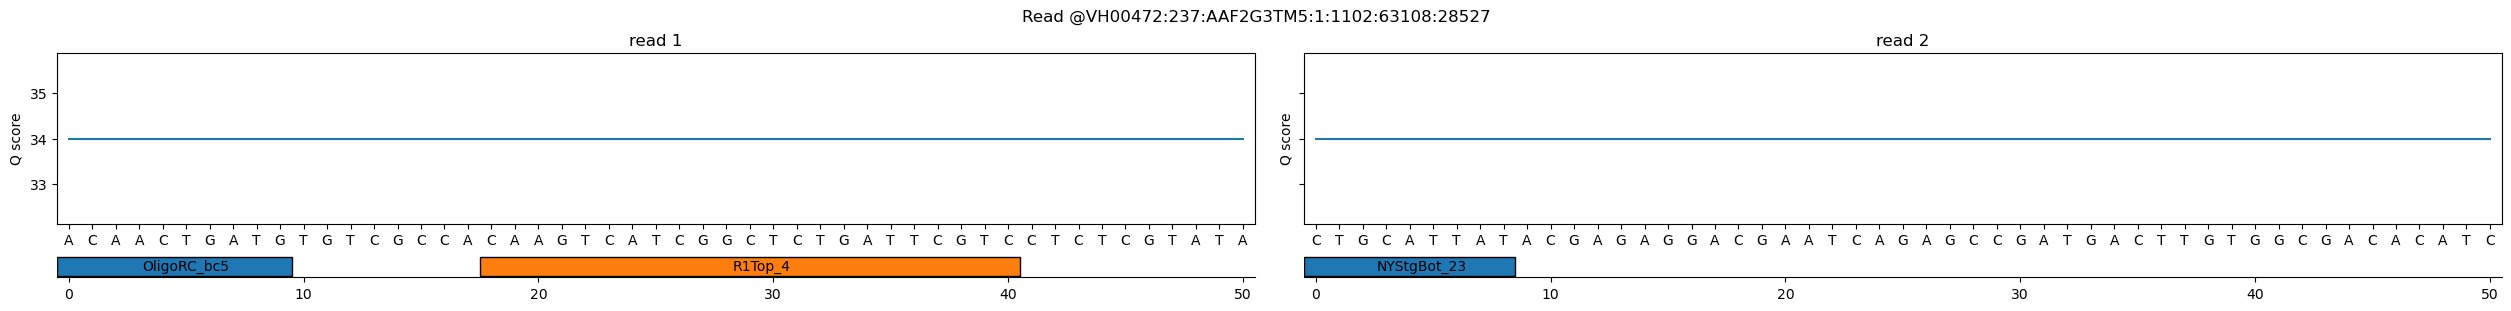

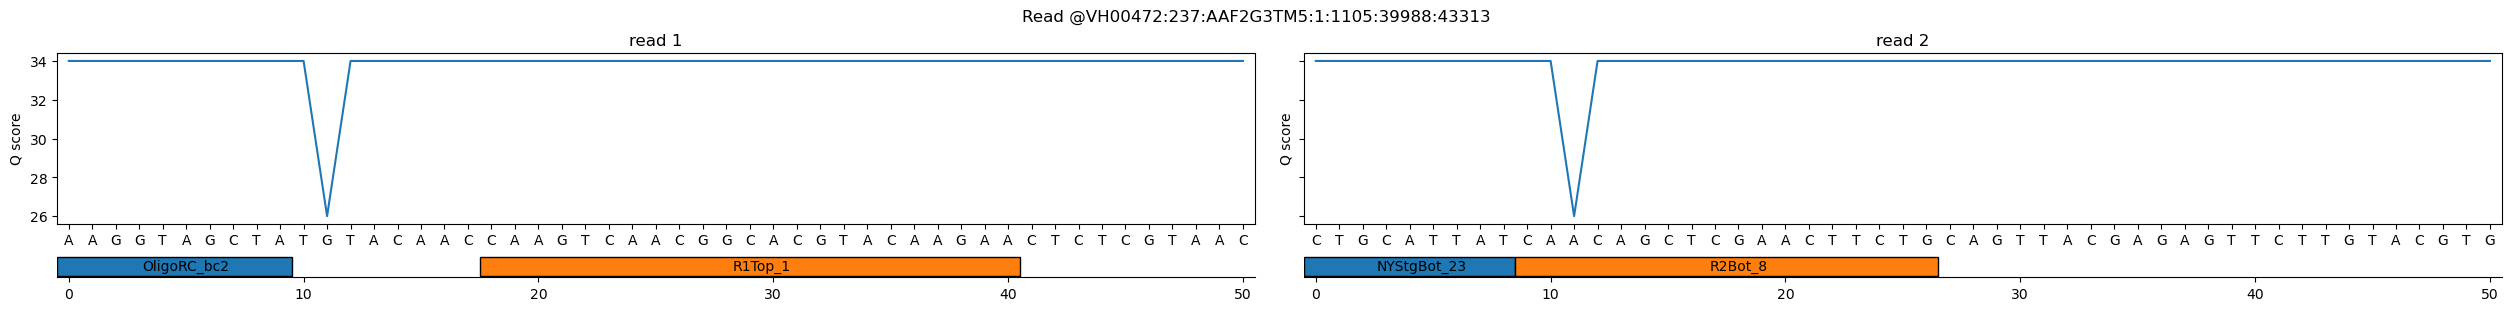

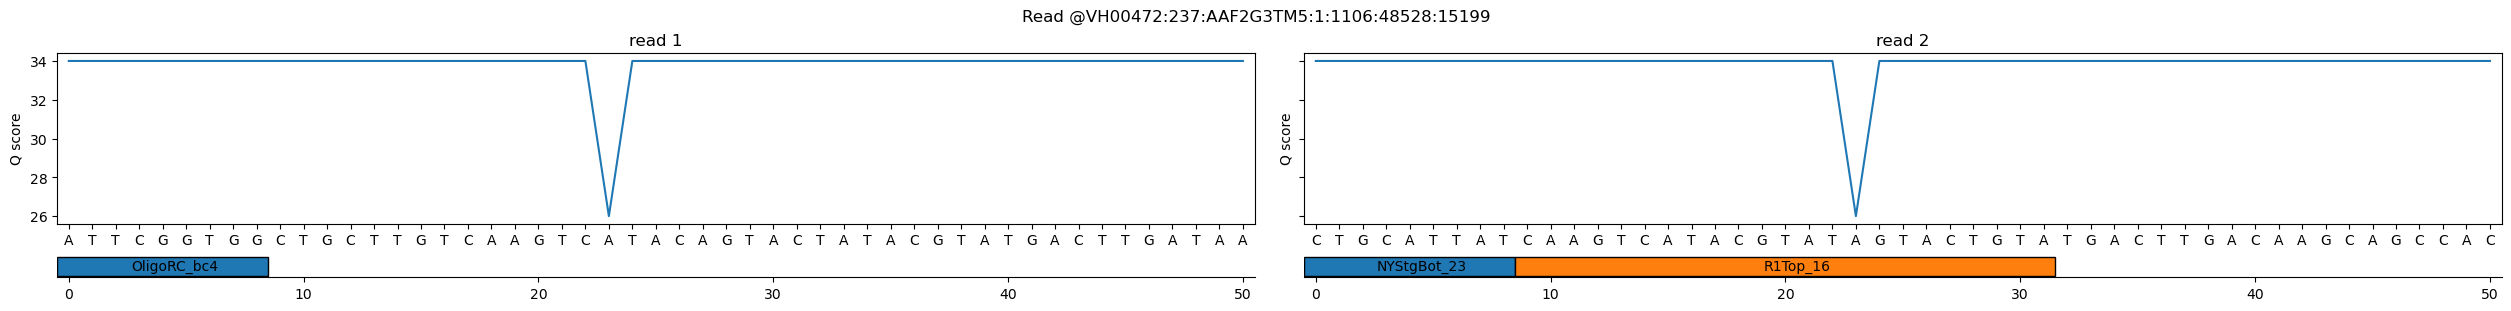

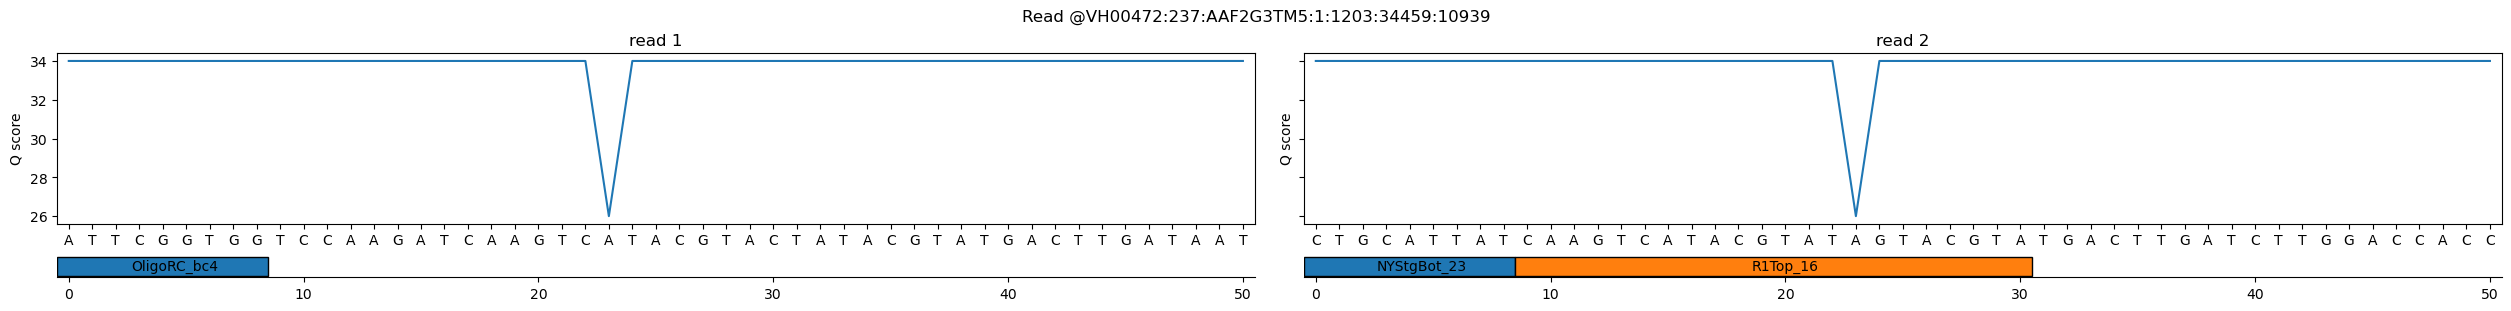

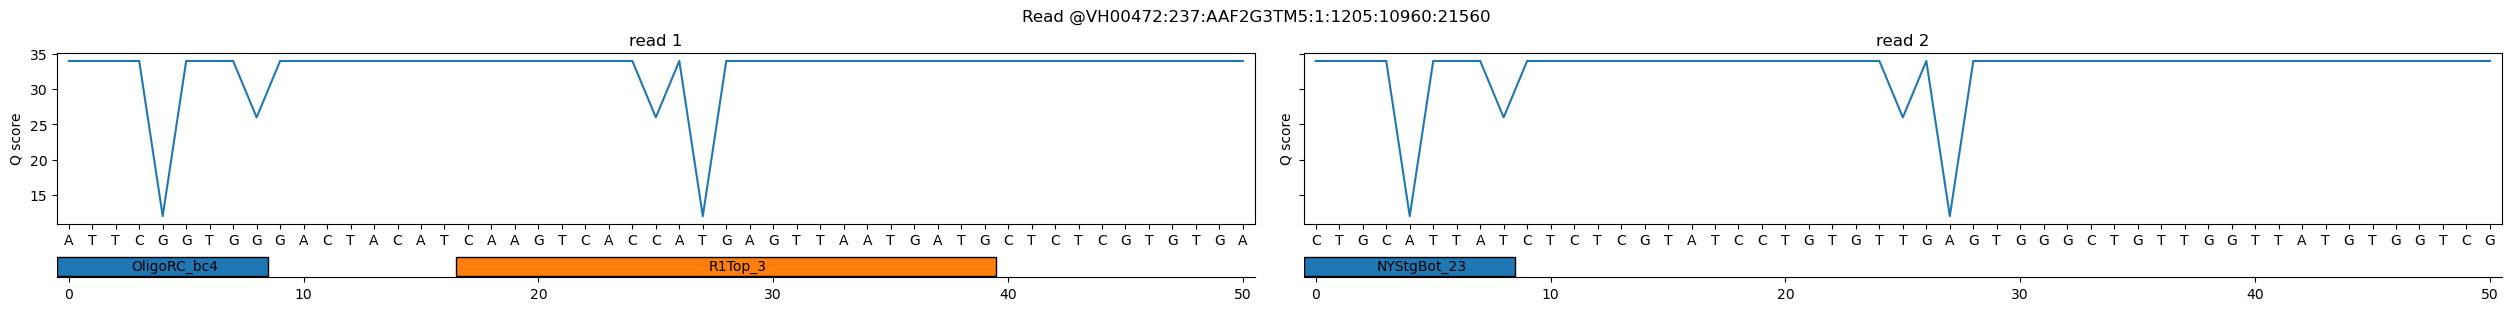

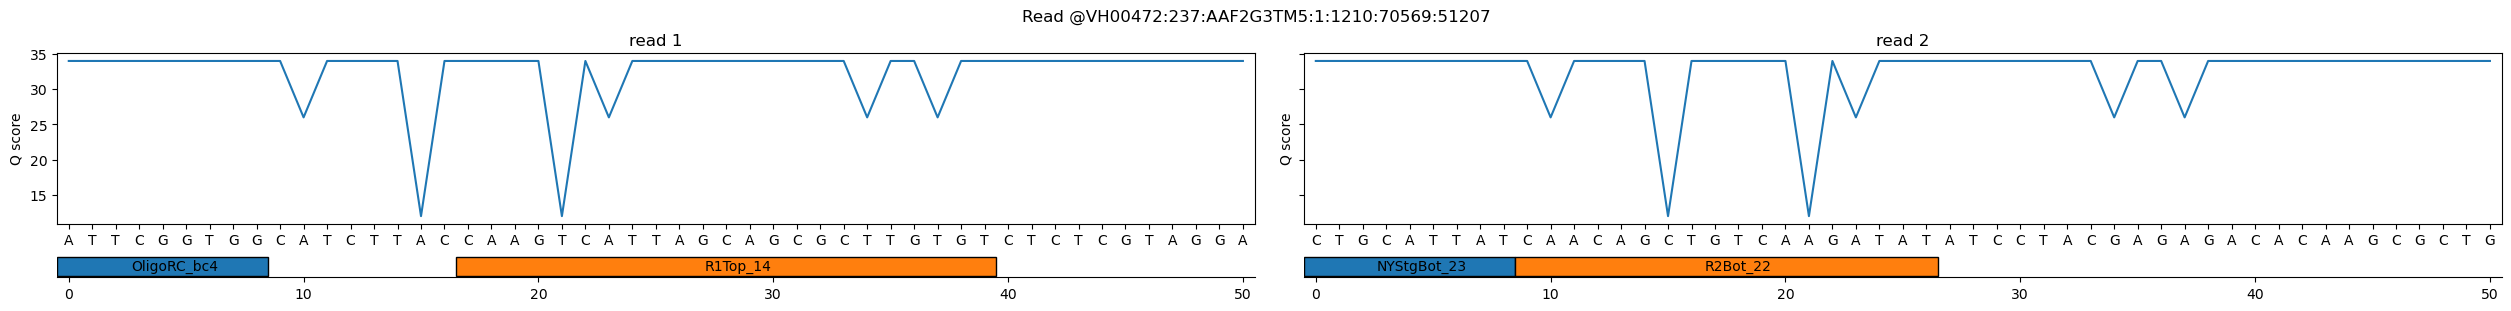

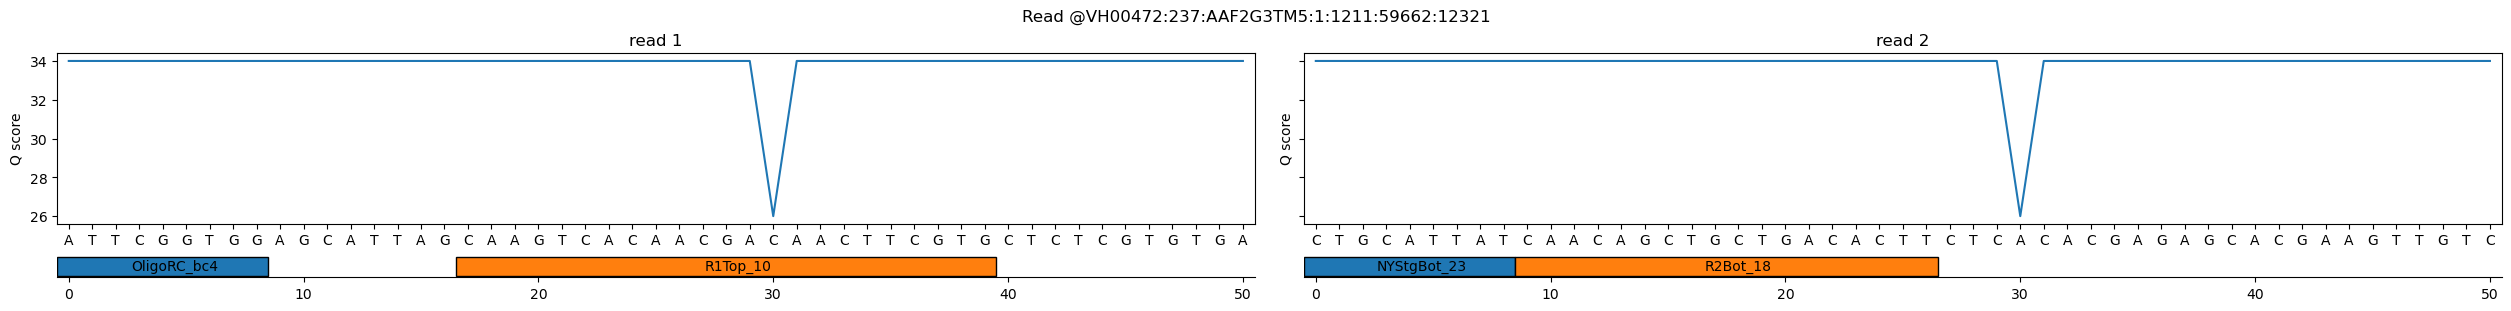

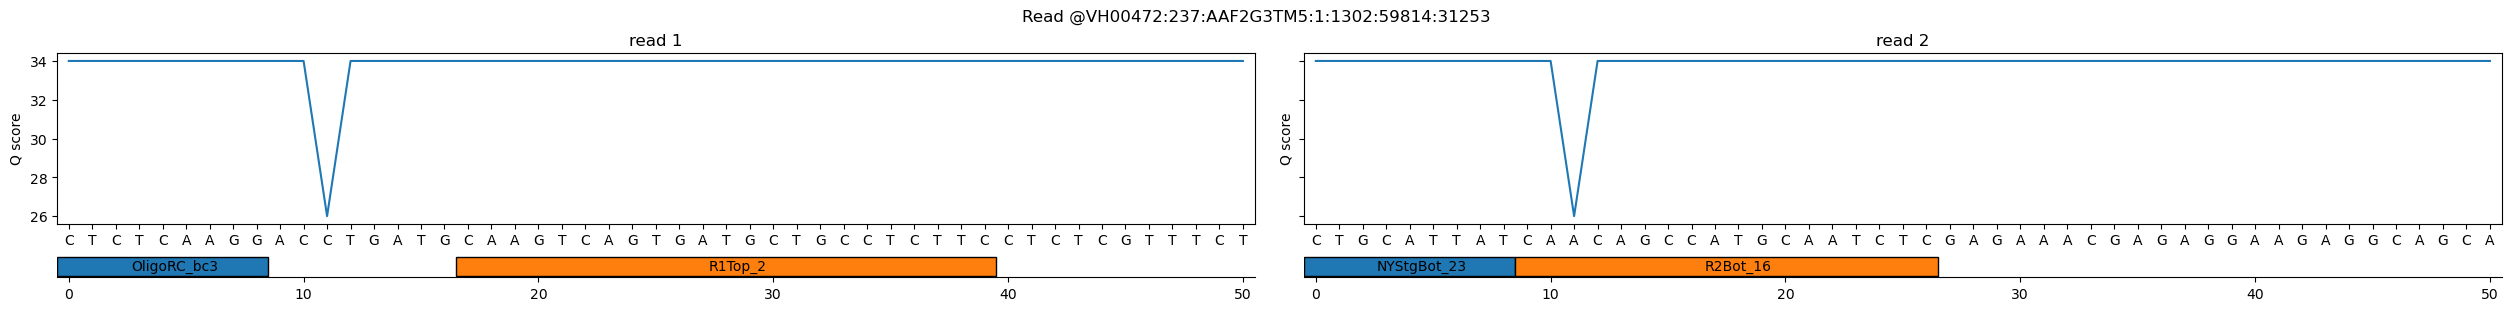

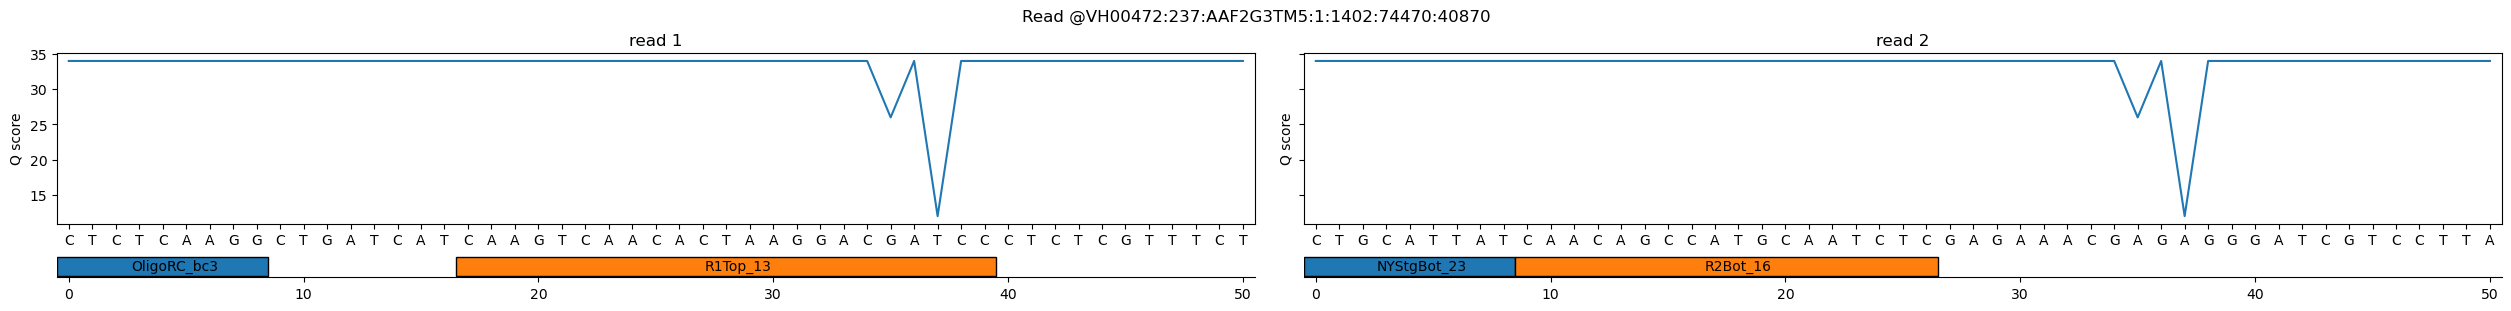

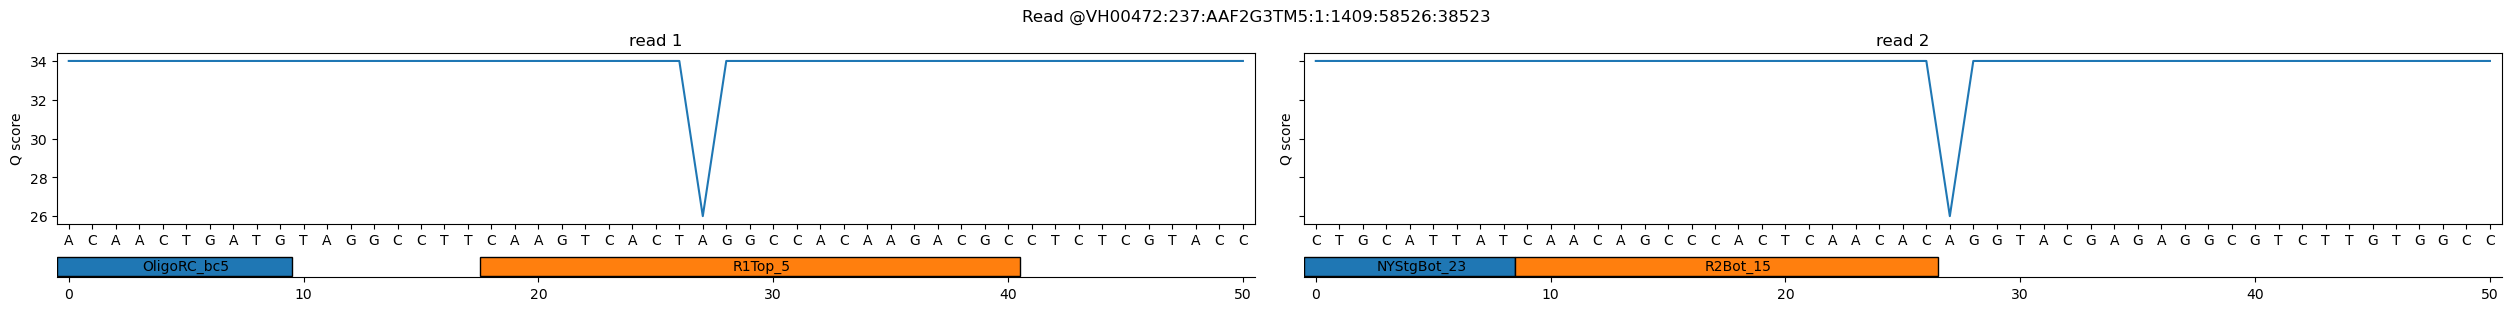

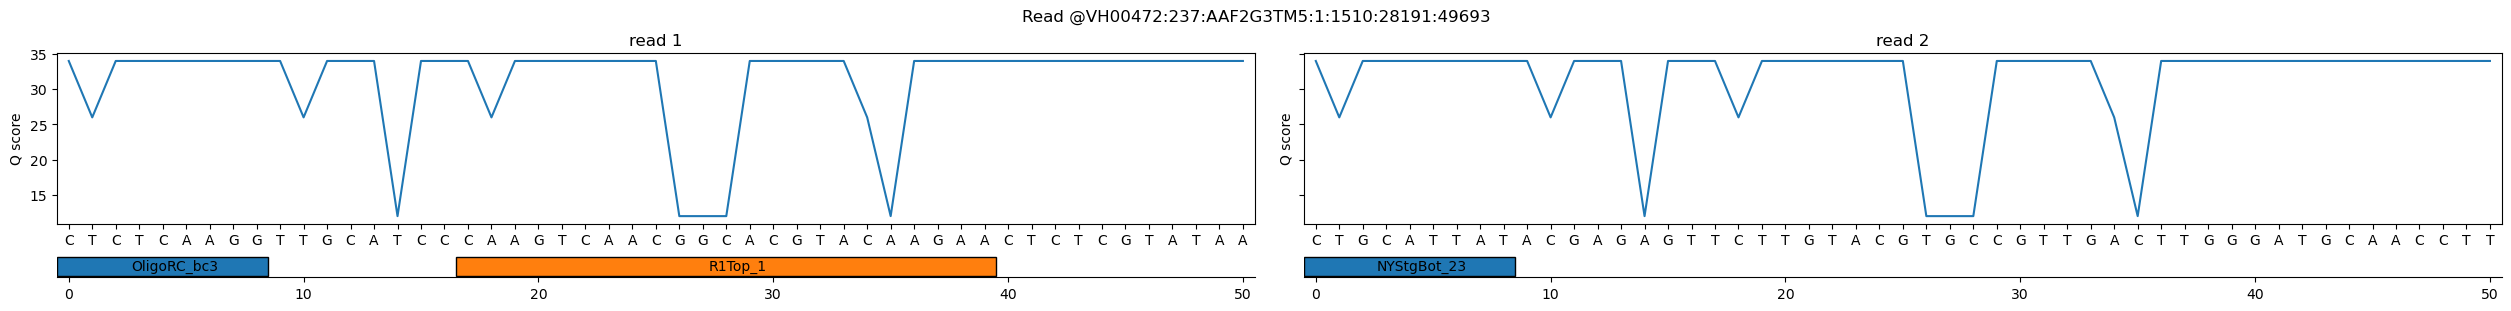

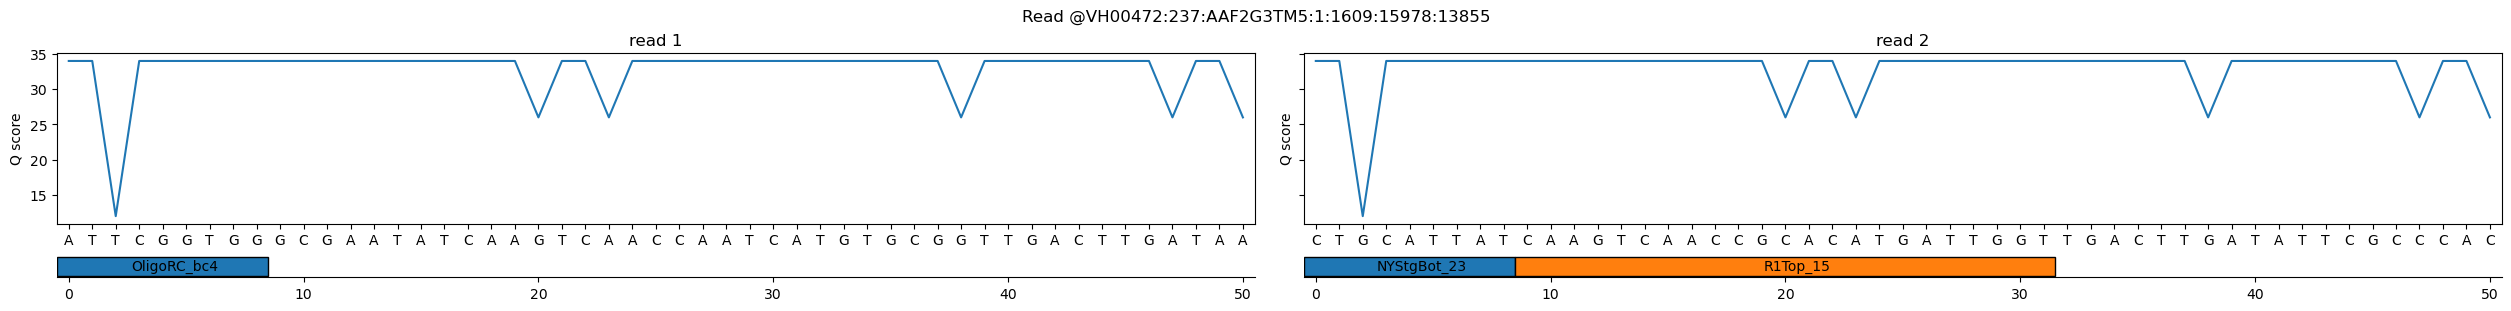

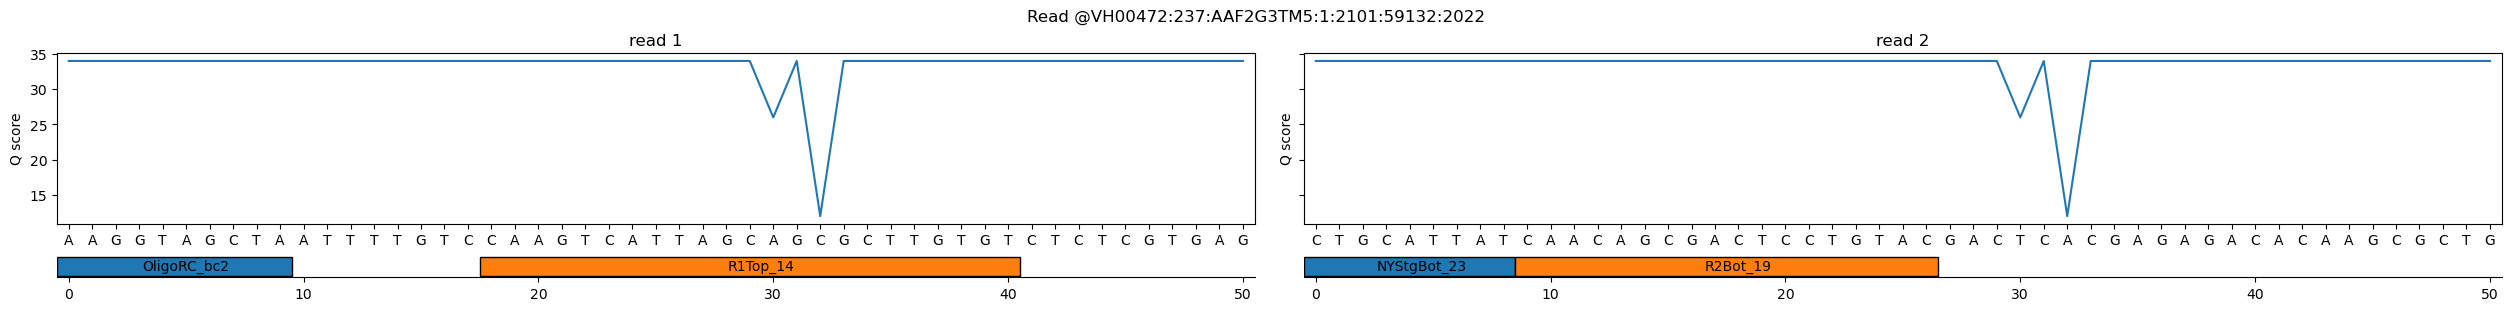

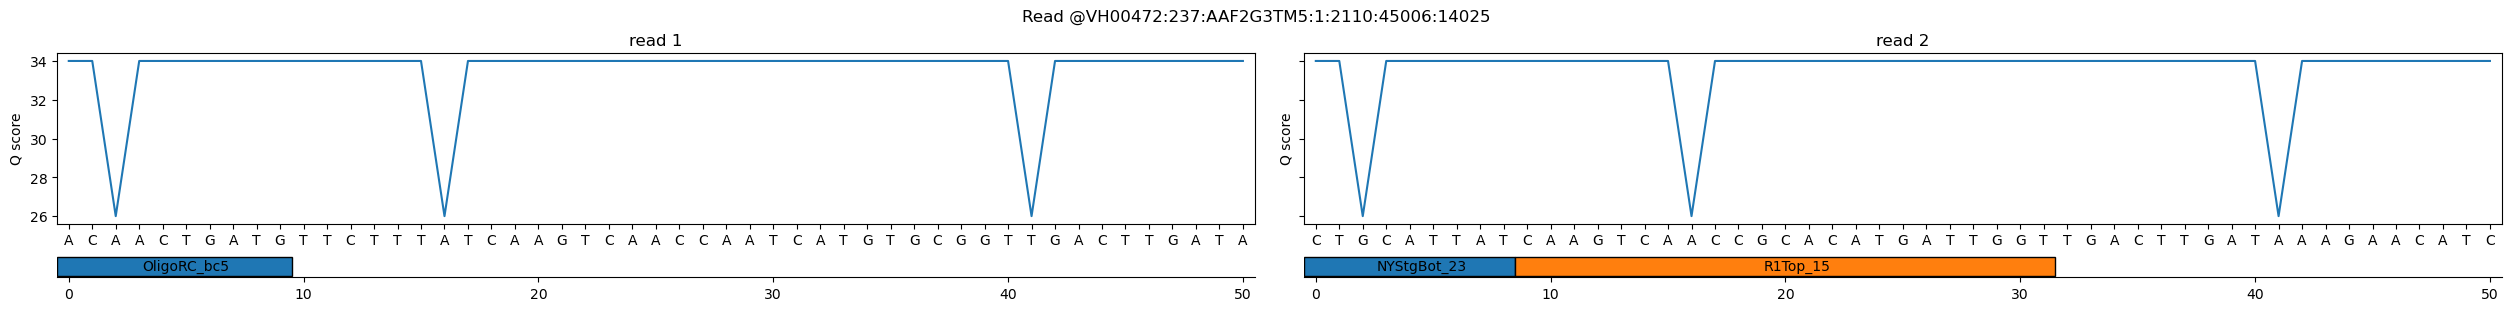

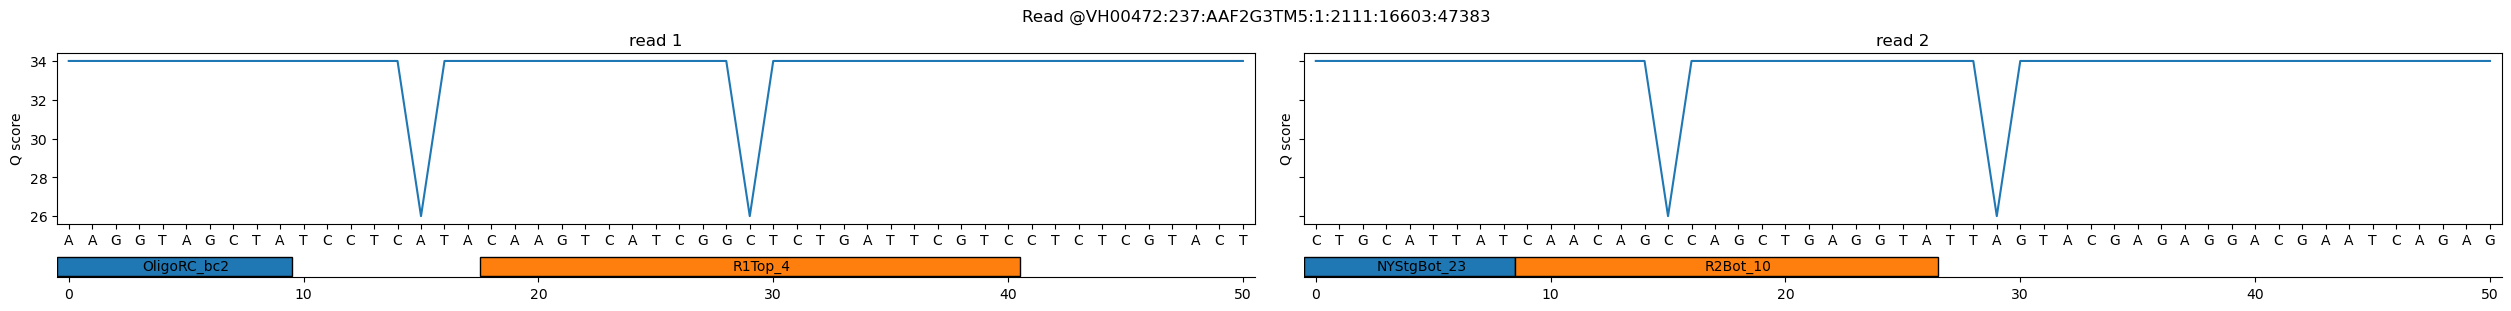

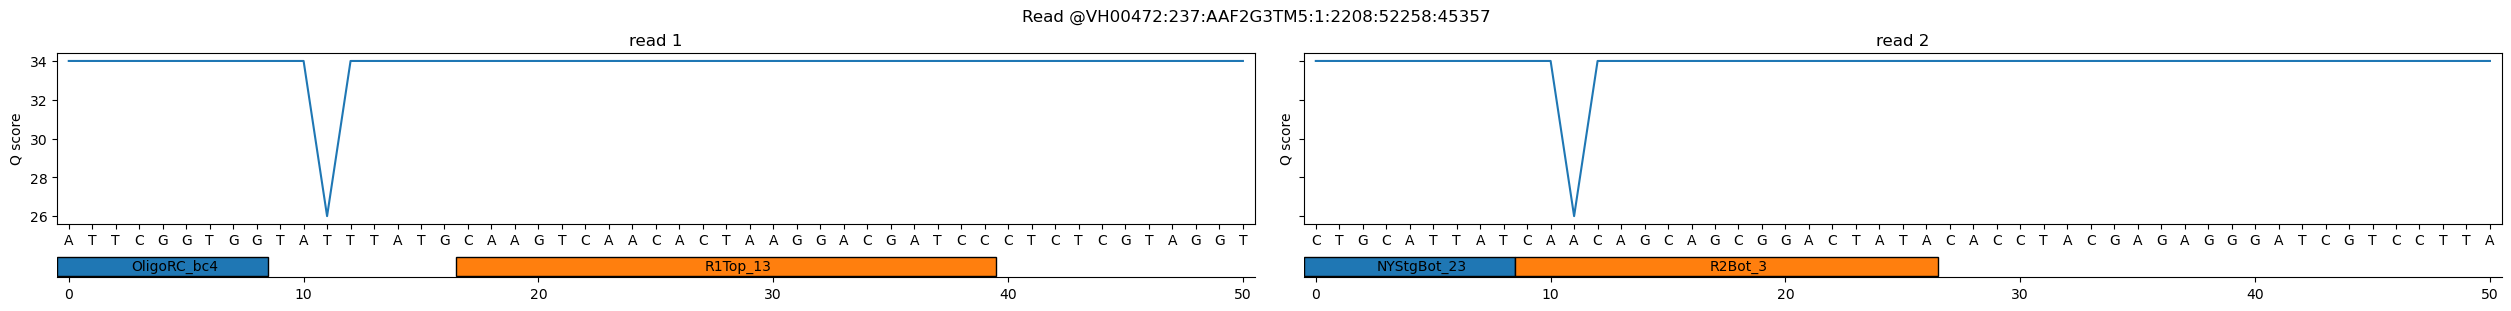

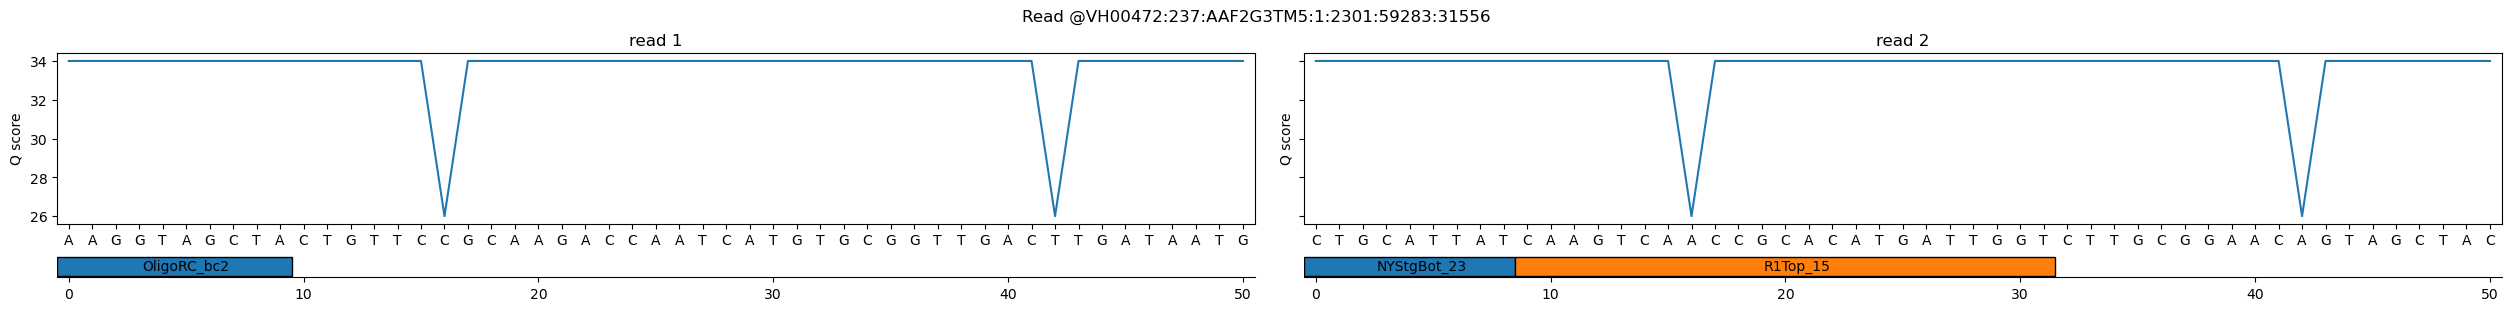

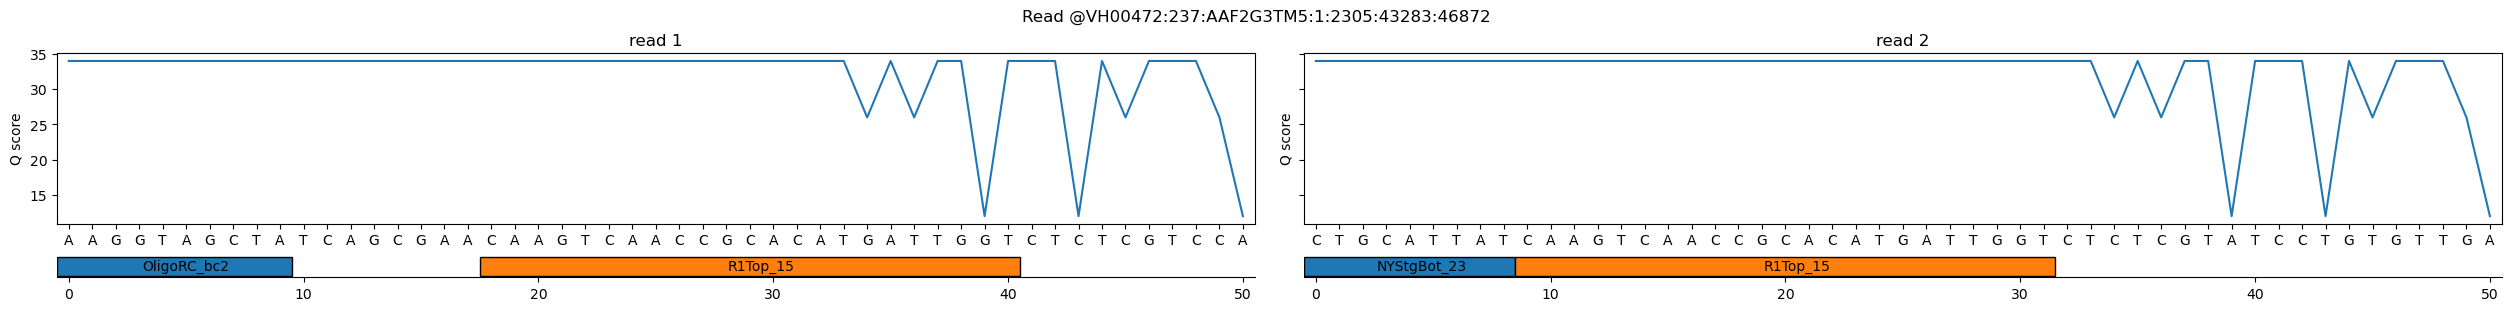

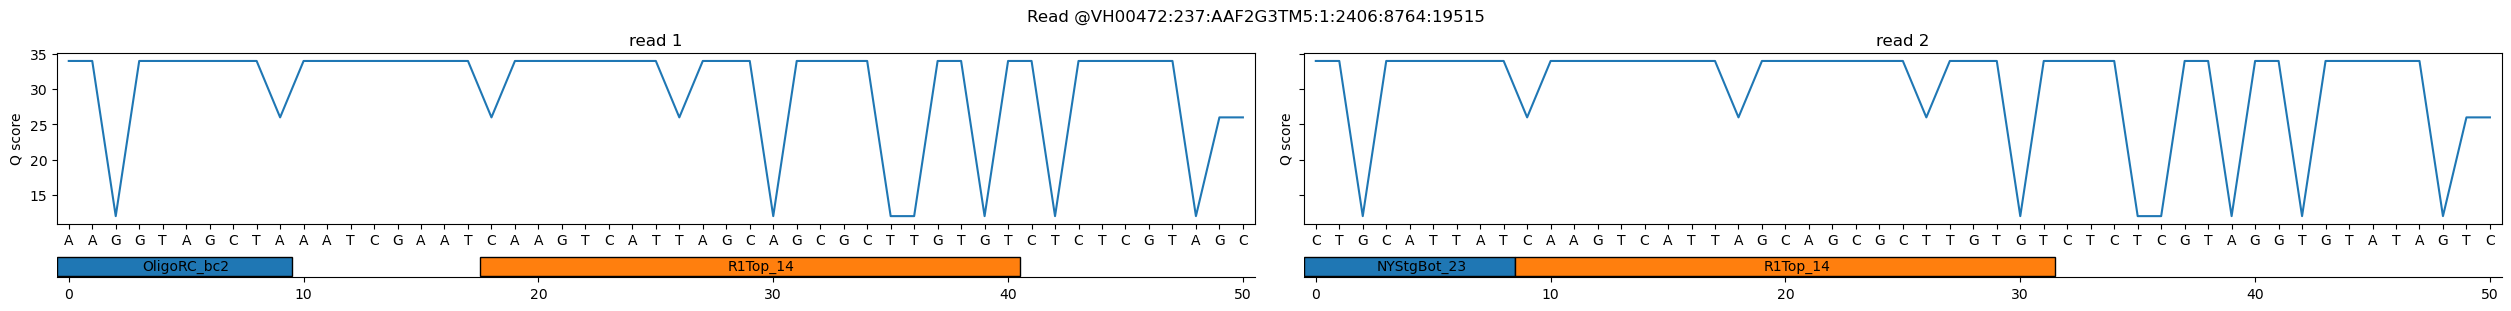

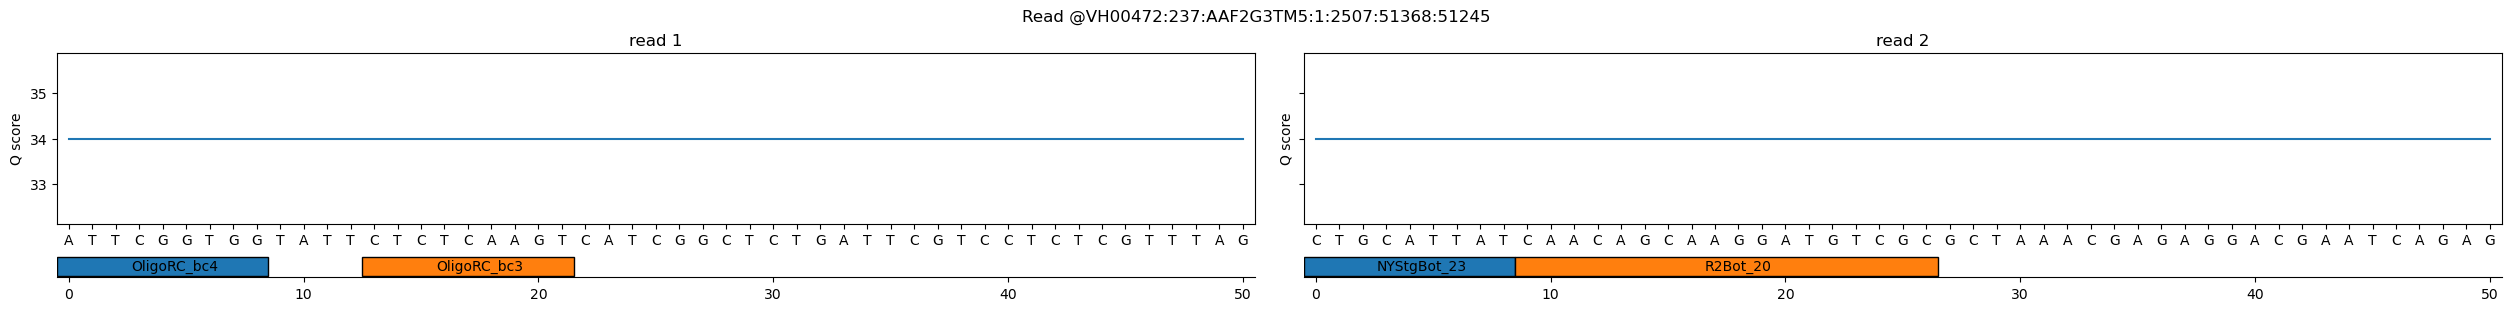

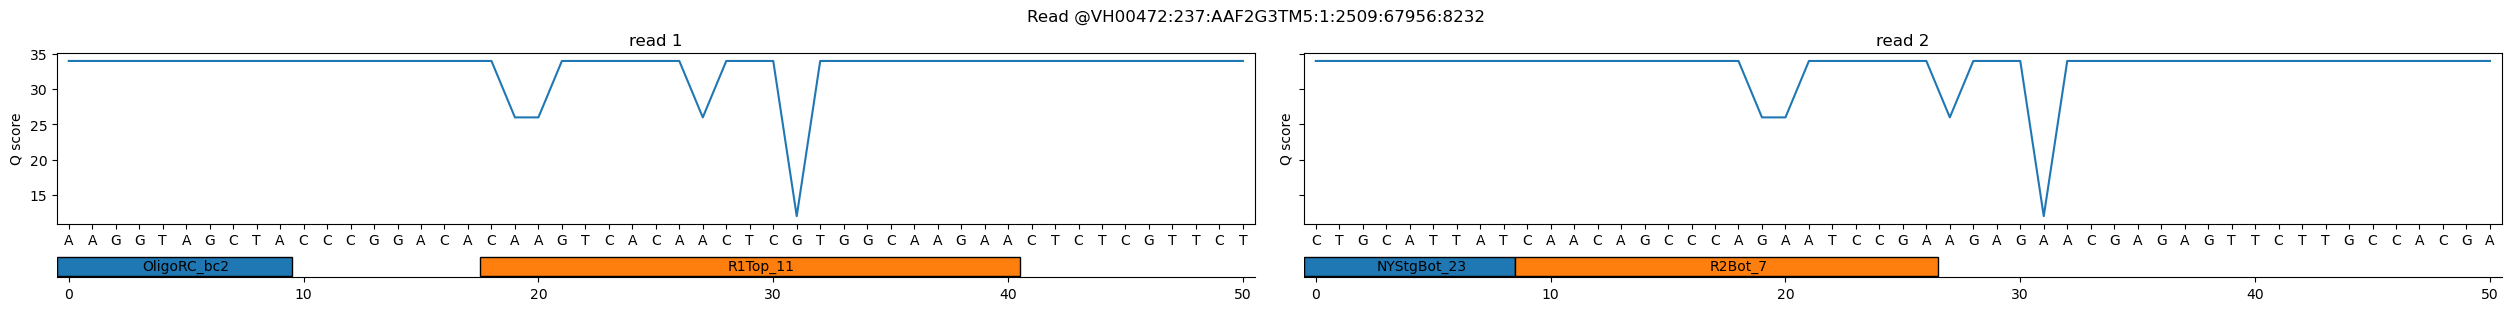

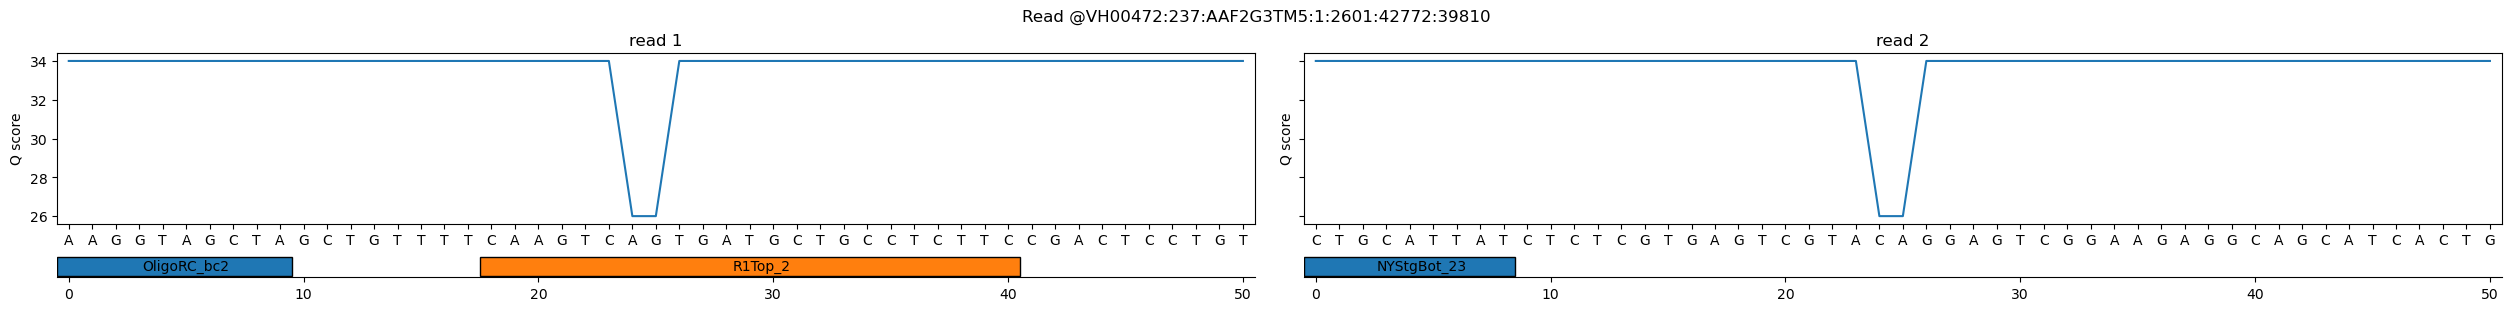

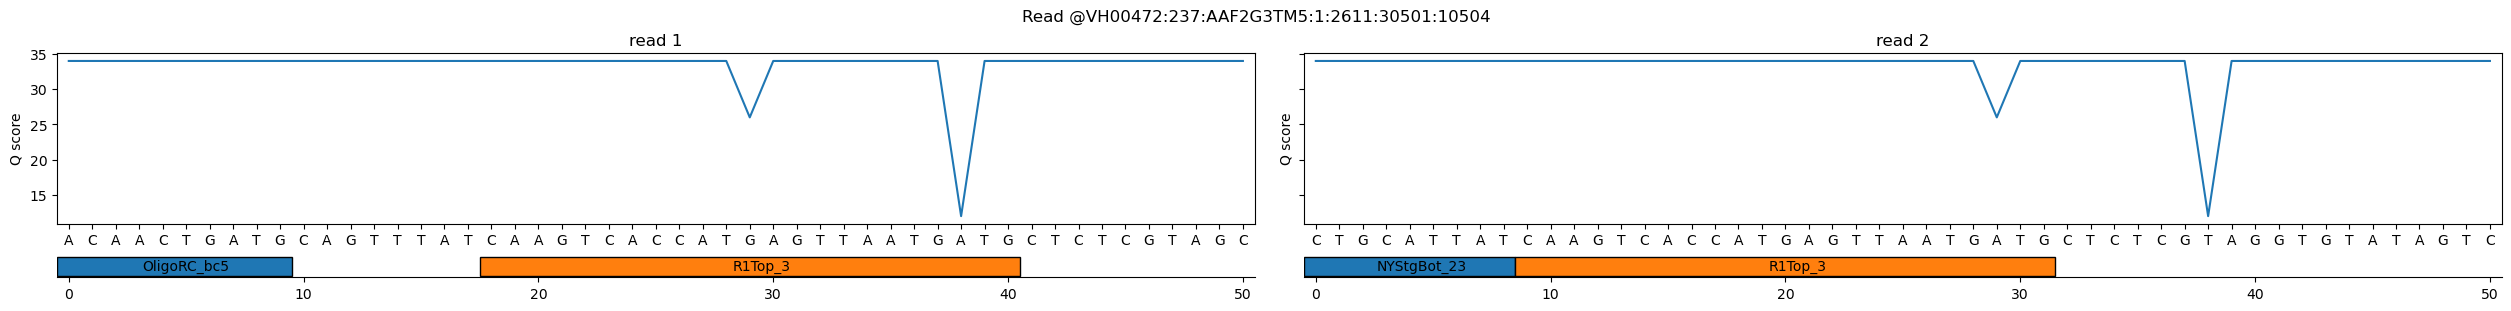

In [157]:
rng = np.random.default_rng(seed=0)
with open(os.path.join(DIR_PROC, 'out_R1-NYStgBot_23-B3.fastq'), 'rt') as f1, \
     open(os.path.join(DIR_PROC, 'out_R2-NYStgBot_23-B3.fastq'), 'rt') as f2:
    for i, ((name1, seq1, _, quals1), (name2, seq2, _, quals2)) in enumerate(zip(
        helpers.fastq_parse(f1),
        helpers.fastq_parse(f2))):
        # sample ~15 read pairs
        if rng.random() > 15/22997:
            continue
        plot_features.plot_read_pair(name1, seq1, quals2, seq2, quals2, reverse2=False, fig_kws=dict(figsize=(25, 3)))

# Sequencing Depth and Duplicates

## Oligo and UMI distribution

The distribution

In [75]:
with pd.option_context('display.float_format', '{:,g}'.format):
    display(df_umi_counts['count'].describe())

count   6.67525e+06
mean        1.62699
std        0.973649
min               1
25%               1
50%               1
75%               2
max              16
Name: count, dtype: float64

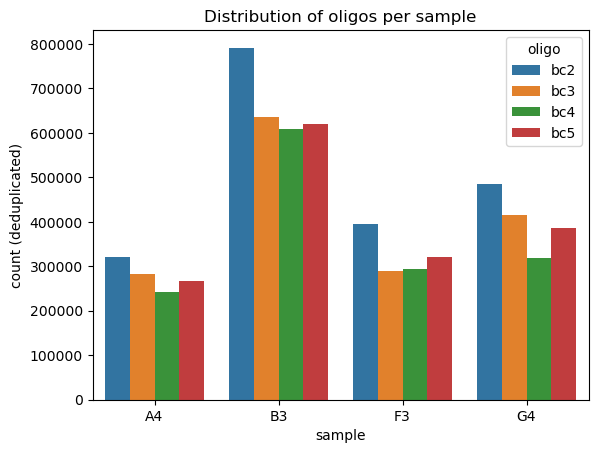

In [76]:
ax = sns.barplot(
    (
        df_umi_counts
        .groupby(['sample', 'oligo'])['count']
        .agg(['size', 'sum'])
        .reset_index()
        .rename(columns=dict(size='count (deduplicated)'))),
    x='sample',
    y='count (deduplicated)',
    hue='oligo')
ax.set_title('Distribution of oligos per sample')
ax.figure.show()

Distribution of UMIs per oligo per sample

/home/btyeh/miniconda3/envs/py3/lib/python3.10/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


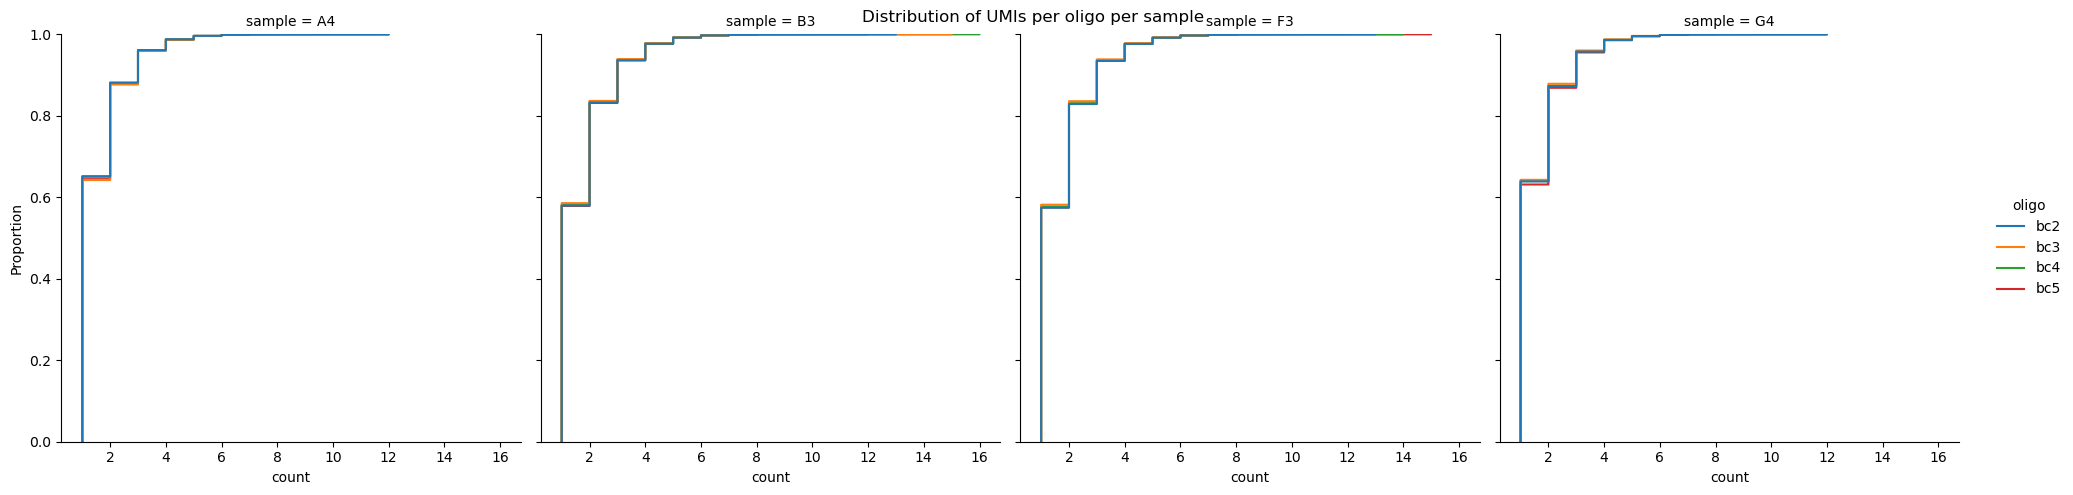

In [77]:
g = sns.displot(
    df_umi_counts,
    kind='ecdf',
    x='count',
    hue='oligo',
    col='sample',
    col_wrap=4)
g.figure.suptitle('Distribution of UMIs per oligo per sample')
g.figure.show()

### Estimate library complexity from sequencing/UMI duplicates

Note: The current method of library complexity estimation assumes that the number of available UMIs far exceeds the number of unique molecules. A better model would account for the possibility of real UMI collisions, and as a consequence of PCR duplicates/sequencing.

In [78]:
def estimate_library_complexity(count_total, count_dedup, max_err=1e-3):
    '''
    See https://github.com/bentyeh/resources/blob/main/bioinformatics/models_genomics.md
    '''
    res = scipy.optimize.minimize_scalar(
      fun=lambda M: (M * (1 - np.exp(-count_total/M)) - count_dedup)**2,
      bracket=(count_dedup, count_total*2)
    )
    assert res.fun < max_err
    return res.x

In [79]:
umi_complexity = 4 * 4**8
print('Maximum UMI complexity:', umi_complexity)

Maximum UMI complexity: 262144


#### Option 1: From all barcodes per sample

In [80]:
complexity_umi_all = df_barcode_counts.groupby('sample')[['count', 'count_dedup']].sum().apply(
    lambda s: estimate_library_complexity(s['count'], s['count_dedup']),
    axis=1)

#### Option 2: From predominant barcode per sample

In [81]:
top_barcode_counts = (
    df_barcode_counts
    .groupby("sample", group_keys=True)
    .apply(lambda group: group.loc[group["count"] == group["count"].max(), ["count", "count_dedup"]])
    .droplevel(1, axis=0))

In [83]:
complexity_umi_top = top_barcode_counts.apply(
    lambda s: estimate_library_complexity(s["count"], s["count_dedup"]), axis=1)

#### Plot

In [84]:
df_data = df_data.merge(
    pd.concat(
        (
            complexity_umi_top.rename("complexity_umi_top"),
            complexity_umi_all.rename("complexity_umi_all"),
        ),
        axis=1,
    ).reset_index(),
    how="left",
    on="sample",
)

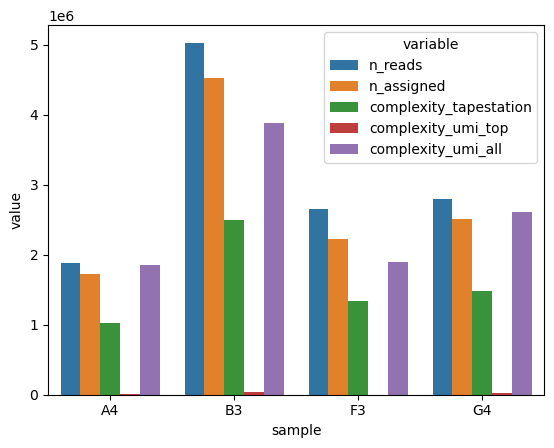

In [85]:
ax = sns.barplot(
    df_data[['sample', 'n_reads', 'n_assigned', 'complexity_tapestation', 'complexity_umi_top', 'complexity_umi_all']] \
        .drop_duplicates() \
        .melt(id_vars='sample'),
    x='sample',
    y='value',
    hue='variable')

#### Estimated coverage and duplication rate

"Coverage" = proportion of physical molecules that were sequenced and assigned.
- Assume sampling `n_assigned` reads from `complexity_tapestation` molecules.

In [86]:
df_data[['sample', 'n_assigned', 'complexity_tapestation']].drop_duplicates() \
    .set_index('sample')\
    .apply(
        lambda s: 1 - scipy.stats.binom.pmf(0, n=s['n_assigned'], p=1/s['complexity_tapestation']),
        axis=1) \
    .rename('coverage')

sample
A4    0.815621
B3    0.835999
F3    0.809435
G4    0.818477
Name: coverage, dtype: float64

Duplication rate = proportion of sequenced and assigned reads that are duplicates

In [87]:
df_barcode_counts.groupby('sample')[['count_dedup', 'count']].sum().pipe(
    lambda df: df.assign(**{
        'duplication rate': (df['count'] - df['count_dedup'])/df['count_dedup']}))

,count_dedup,count,duplication rate
sample,,,
A4,1114233,1705994,0.531093
B3,2656046,4468344,0.682329
F3,1300689,2199937,0.691363
G4,1604282,2486314,0.549799


In [88]:
df_data[['sample', 'n_assigned', 'complexity_tapestation']].drop_duplicates() \
    .set_index('sample')\
    .apply(
        lambda s:
            scipy.stats.binom.mean(n=s['n_assigned'], p=1/s['complexity_tapestation']) / \
            (1 - scipy.stats.binom.pmf(0, n=s['n_assigned'], p=1/s['complexity_tapestation'])),
        axis=1) \
    .map(lambda s: (s - 1) / s) \
    .rename('duplication rate')

sample
A4    0.517601
B3    0.537581
F3    0.511730
G4    0.520341
Name: duplication rate, dtype: float64

# Ligation QC

| Round    | Tags used (wells) | Tags used (ID) | Tags added during pooling |
| -------- | ----------------- | -------------- | ------------------------- |
| R1       | A1-A12, B1-B10    | 1-12, 13-22    | B11 (23), B12 (24)        |
| R2       | C1-C12, D1-D10    | 1-12, 13-22    | D11 (23), D12 (24)        |
| R3       | E1-E12, F1-F10    | 1-12, 13-22    | F11 (23), F12 (24)        |
| NYLigOdd | A1-A12, B1-B10    | 1-12, 13-22    | B11 (23), B12 (24)        |

In [89]:
rounds_to_pooled_tags = {
    'R1': (23, 24),
    'R2': (23, 24),
    'R3': (23, 24),
    'NYLigOdd': (23, 24)
}

Expected coverage and duplication rate

In [99]:
with pd.option_context('display.max_rows', 1000):
    display(df_tag_counts.loc[(df_tag_counts['round'] == 'NYLigOdd') & (df_tag_counts['sample'] == 'F3')])

,sample,round,tag,deduplication,count
219,F3,NYLigOdd,1,yes,93
220,F3,NYLigOdd,2,yes,140
221,F3,NYLigOdd,3,yes,225
222,F3,NYLigOdd,4,yes,168
223,F3,NYLigOdd,5,yes,146
224,F3,NYLigOdd,6,yes,6427
225,F3,NYLigOdd,7,yes,218
226,F3,NYLigOdd,8,yes,99
227,F3,NYLigOdd,9,yes,265
228,F3,NYLigOdd,10,yes,301


/home/btyeh/miniconda3/envs/py3/lib/python3.10/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


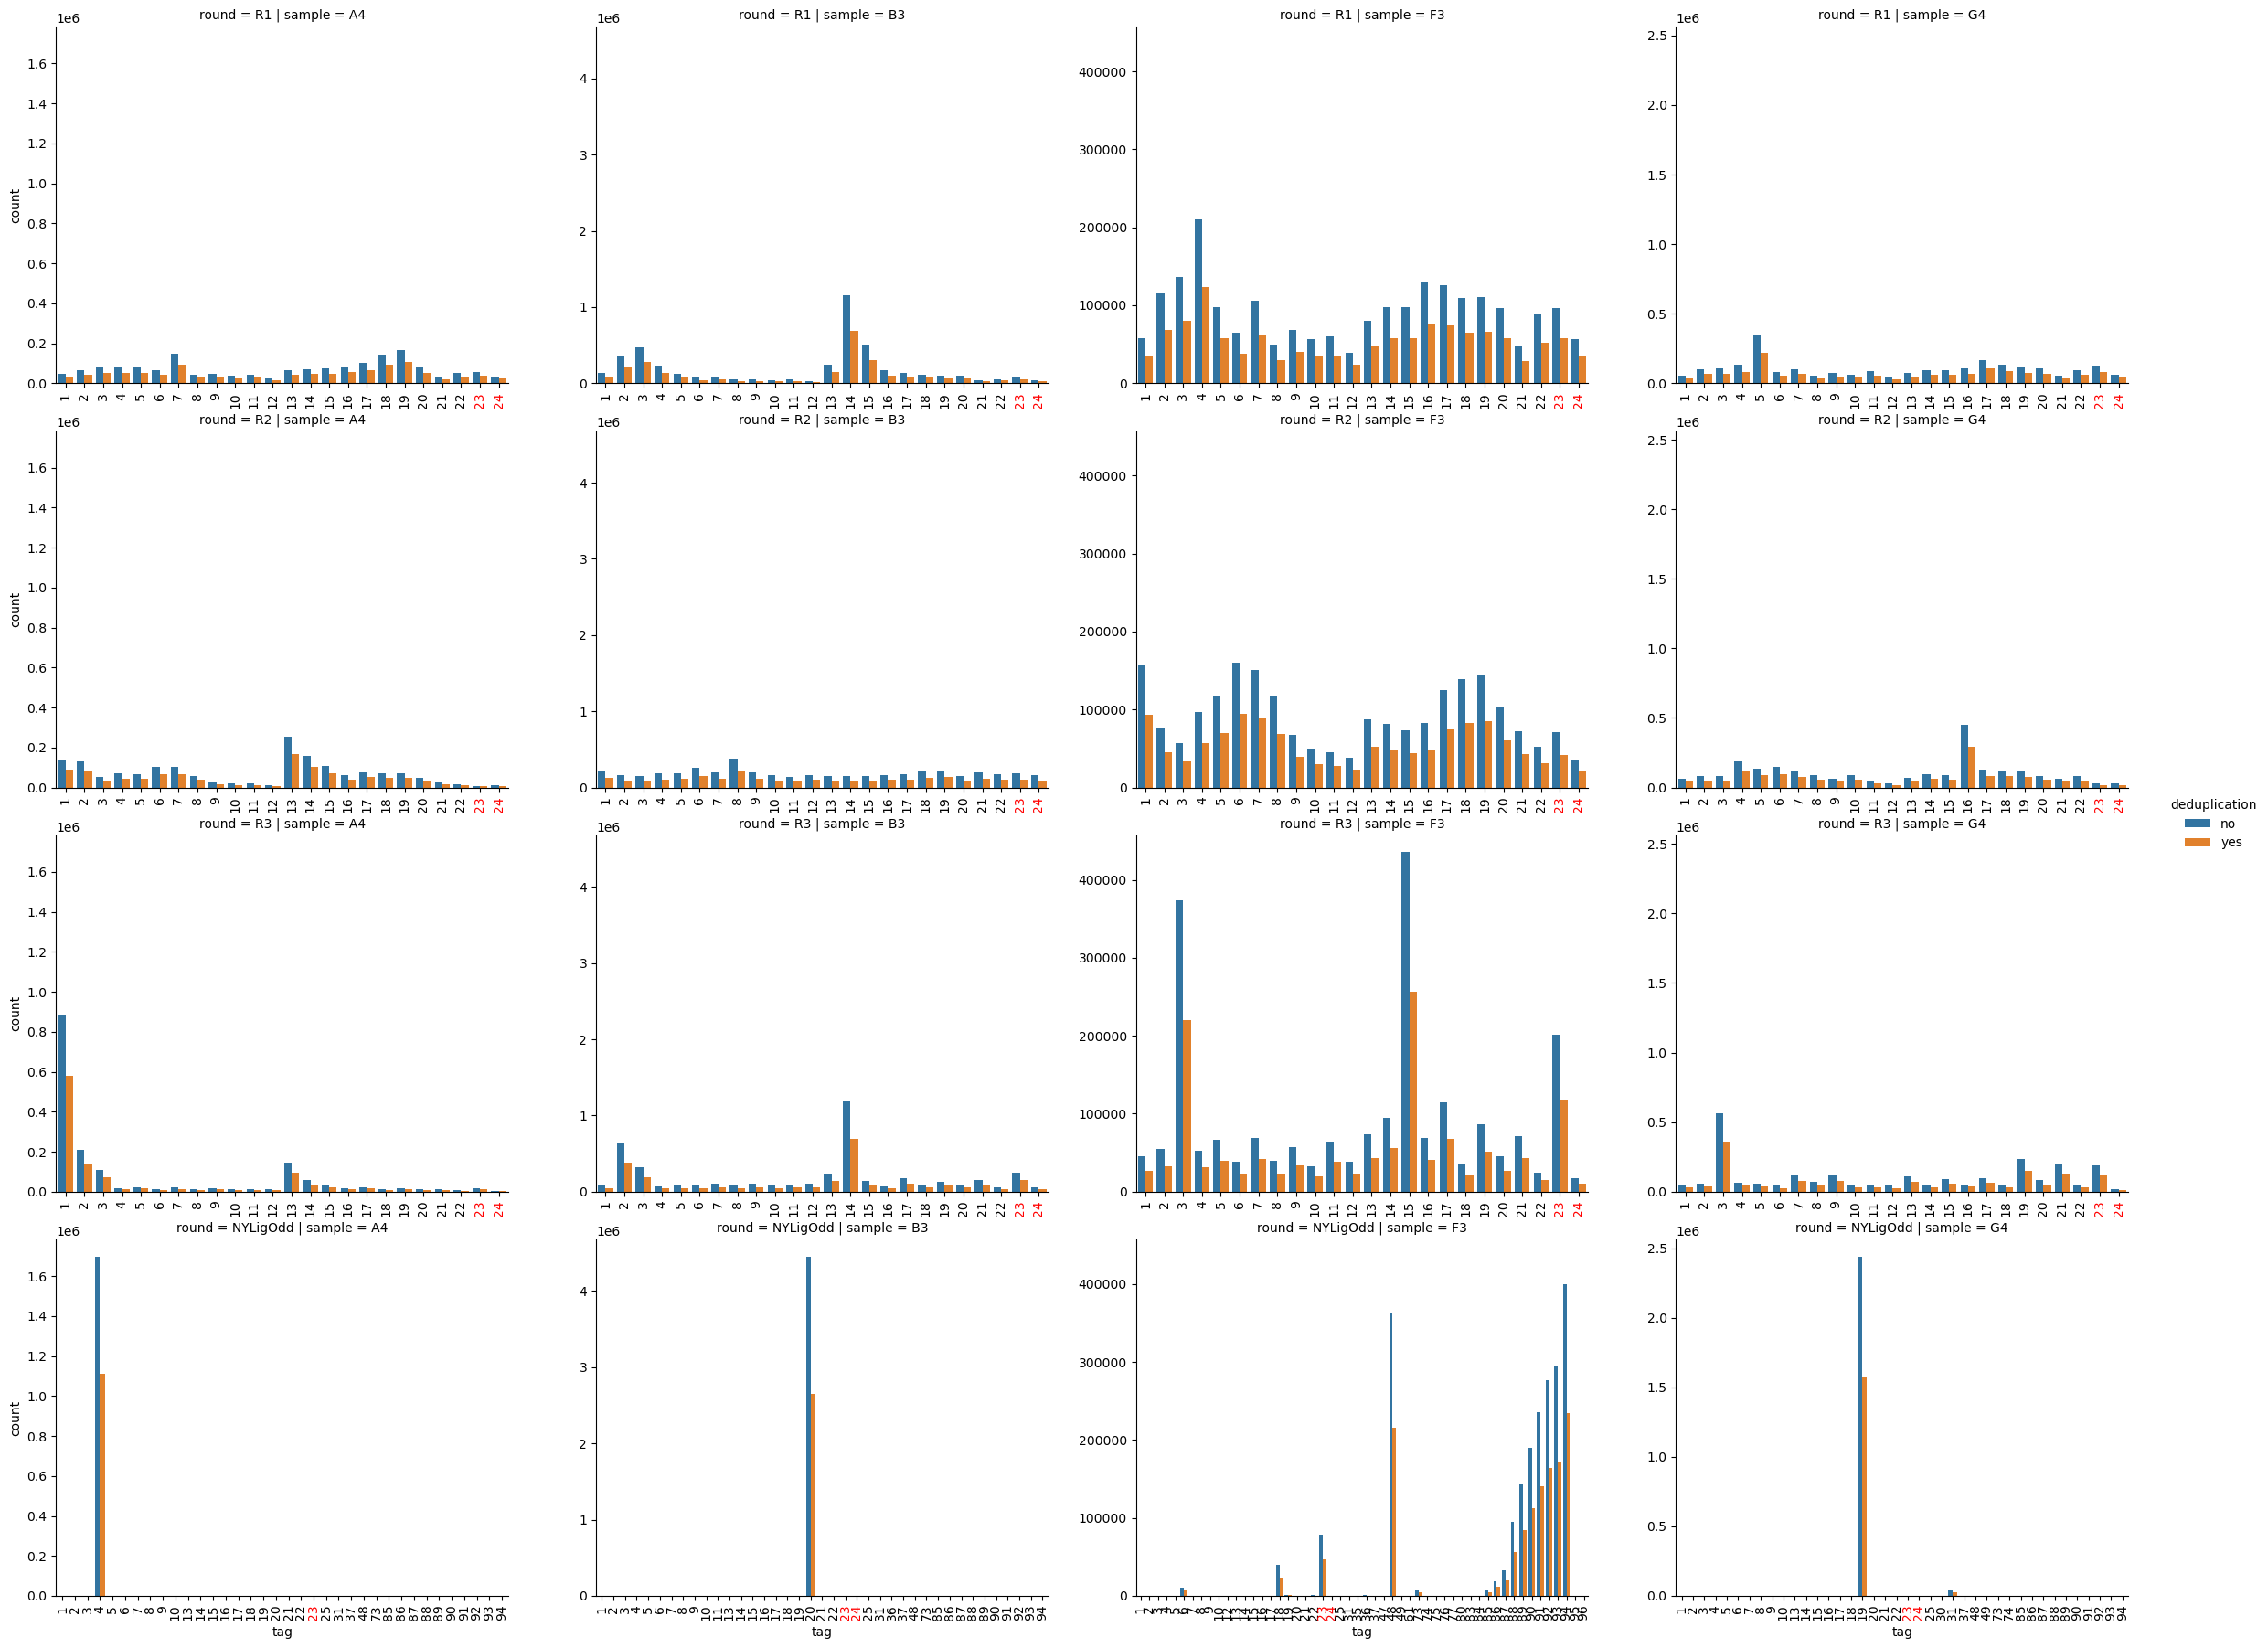

In [124]:
g = sns.catplot(
    df_tag_counts,
    kind='bar',
    x='tag',
    y='count',
    row='round',
    row_order=ROUNDS,
    hue='deduplication',
    col='sample',
    sharex=False,
    sharey='col')

# red color for xticklabels corresponding to tags added during pooling
for (r, sample), ax in g.axes_dict.items():
    for text in ax.get_xticklabels():
        if int(text.get_text()) in rounds_to_pooled_tags[r]:
            text.set_color('red')
    ax.set_xticklabels(ax.get_xticklabels(), rotation=90)

g.figure.set_size_inches(25, 18)

g.figure.savefig(
    os.path.join(DIR_RESULTS, 'tag_counts_by_sample.pdf'),
    bbox_inches='tight',
    dpi=300)

Observations
- In any subplot with multiple "peaks", the peaks tend to be 12 indices apart (one row apart on the tag plates), consistent with ligation of another tag upon pooling. (I pooled by first using a multichannel pipette to transfer 1 row into the next row, then individually pooling the wells across the row.)
- Ignoring sample F3 as an outlier, the other samples consistently show an extremely clean NYLigOdd round but very noisy R1-R3 rounds.
- Overall, ligation by a "pooled tag" was no higher than other background.

## Ligation of pooled tags

1. (Distribution over samples) For a given round, what proportion of tags were pooled tags?
2. (Distribution over samples) For a given round, what proportion of tags were accounted by each pooled tag?
4. (Distribution over samples) For a given partial (3 out of 4 rounds) barcode, what proportion of the "missing" round is made up of pooled tags?

In [100]:
df_pooled_tags_counts = (
    df_tag_counts
    .groupby(["sample", "round", "deduplication"], group_keys=False)
    .apply(lambda group: (
        group
        .assign(total=group["count"].sum())
        .loc[group["tag"].isin(rounds_to_pooled_tags[group.iloc[0]["round"]])]))
    .pipe(lambda df: df.assign(proportion=df['count']/df['total']))
    .sort_values(['deduplication', 'round', 'sample', 'proportion'])
    .reset_index(drop=True)
)

In [101]:
# assert that the number of counts observed at each round is the same for all samples
assert df_pooled_tags_counts.groupby(['sample', 'deduplication'])['total'].agg(lambda x: len(np.unique(x)) == 1).all()

/home/btyeh/miniconda3/envs/py3/lib/python3.10/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


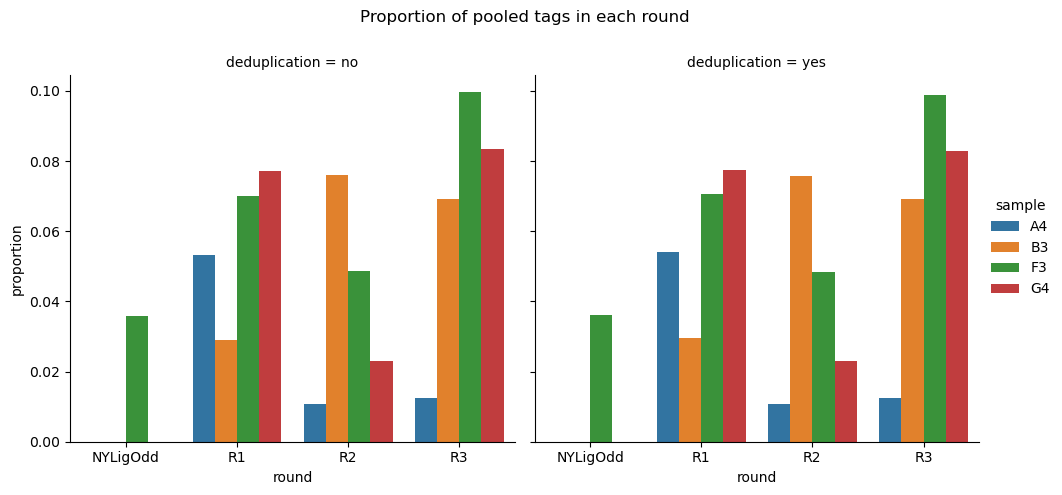

In [102]:
g = sns.catplot(
    df_pooled_tags_counts.groupby(['sample', 'round', 'deduplication'], as_index=False)['proportion'].sum(),
    kind='bar',
    x='round',
    y='proportion',
    hue='sample',
    col='deduplication')
g.figure.subplots_adjust(top=0.85)
g.figure.suptitle('Proportion of pooled tags in each round')
g.figure.show()

/home/btyeh/miniconda3/envs/py3/lib/python3.10/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


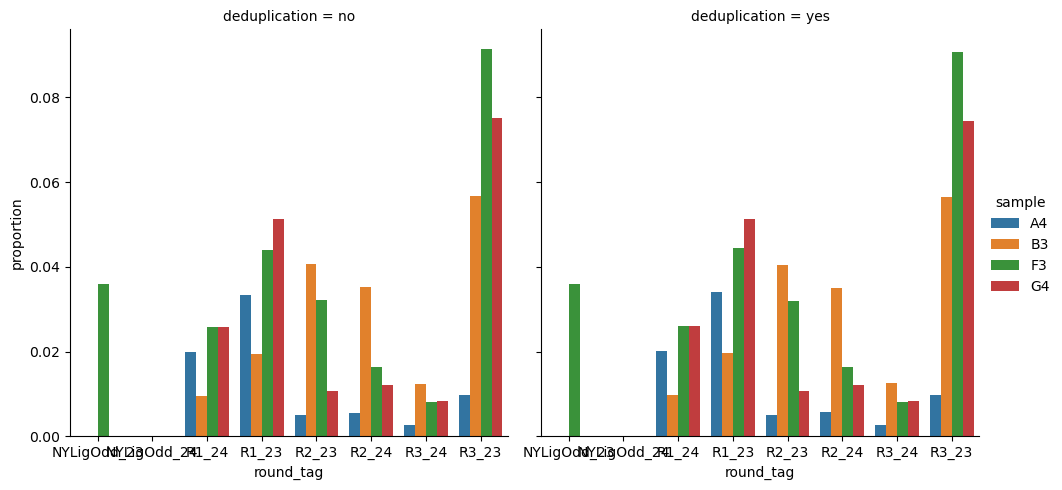

In [103]:
sns.catplot(
    df_pooled_tags_counts.assign(
        round_tag=df_pooled_tags_counts['round'].str.cat(df_pooled_tags_counts['tag'].astype(str), sep='_')),
    kind='bar',
    x='round_tag',
    y='proportion',
    hue='sample',
    col='deduplication')
g.figure.subplots_adjust(top=0.85)
g.figure.suptitle('Proportion of pooled tags in each round')
g.figure.show()

In [104]:
df_pooled_tag_proportion_per_partial_barcode = []
for i in range(len(ROUNDS)):
    partial_rounds = ROUNDS[:i] + ROUNDS[i+1:]
    pooled_round = ROUNDS[i]
    df_pooled_tag_proportion_per_partial_barcode.append((
        df_barcode_counts
        .groupby(['sample'] + partial_rounds, observed=True, as_index=False)
        .apply(lambda group:
               group.loc[group[pooled_round].isin(rounds_to_pooled_tags[pooled_round]), ['count', 'count_dedup']].sum(axis=0) / 
               group[['count', 'count_dedup']].sum(axis=0))
        .assign(**{pooled_round: -1, 'round': pooled_round})
        .rename(columns={'count': 'proportion', 'count_dedup': 'proportion_dedup'})
    ))
df_pooled_tag_proportion_per_partial_barcode = pd.concat(df_pooled_tag_proportion_per_partial_barcode) \
    .astype(dict(round='category'))

/home/btyeh/miniconda3/envs/py3/lib/python3.10/site-packages/seaborn/axisgrid.py:118: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  self._figure.tight_layout(*args, **kwargs)
/home/btyeh/miniconda3/envs/py3/lib/python3.10/site-packages/seaborn/axisgrid.py:118: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  self._figure.tight_layout(*args, **kwargs)
/home/btyeh/miniconda3/envs/py3/lib/python3.10/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


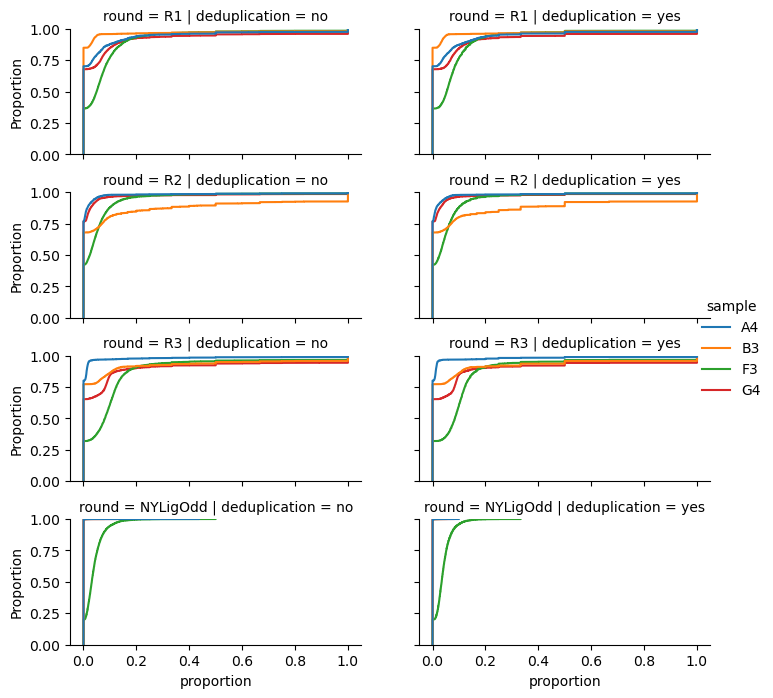

In [105]:
g = sns.displot(
    kind='ecdf',
    data=(
        df_pooled_tag_proportion_per_partial_barcode
        .rename(columns={'proportion': 'no', 'proportion_dedup': 'yes'}) \
        .melt(id_vars=['sample', 'round'],
              value_vars=['no', 'yes'],
              var_name='deduplication',
              value_name='proportion')),
    x='proportion',
    hue='sample',
    row='round',
    row_order=ROUNDS,
    col='deduplication',
    facet_kws={'gridspec_kws': dict(hspace=0.3)})
g.figure.set_size_inches((8, 8))

/home/btyeh/miniconda3/envs/py3/lib/python3.10/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


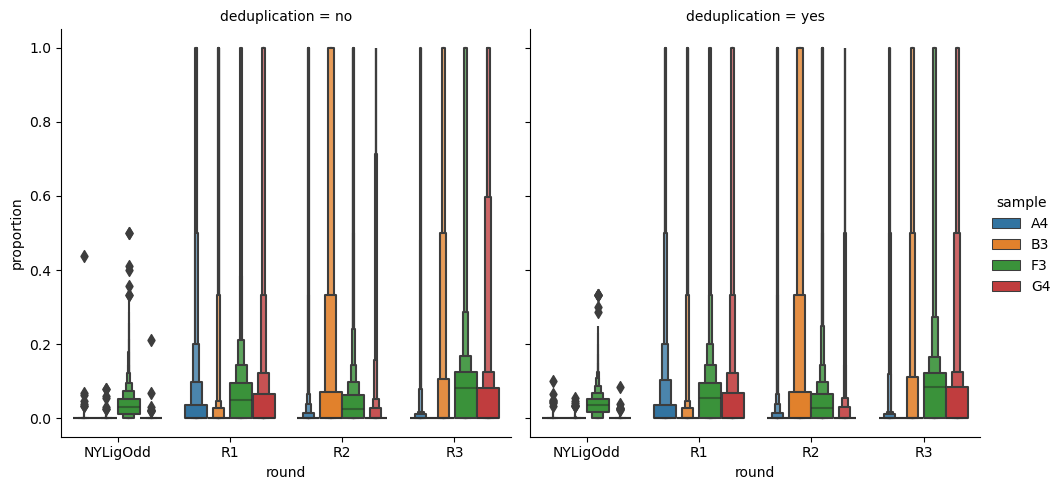

In [107]:
sns.catplot(
    kind='boxen',
    data=df_pooled_tag_proportion_per_partial_barcode \
        .rename(columns={'proportion': 'no', 'proportion_dedup': 'yes'}) \
        .melt(id_vars=['sample', 'round'],
              value_vars=['no', 'yes'],
              var_name='deduplication',
              value_name='proportion'),
    x='round',
    y='proportion',
    hue='sample',
    col='deduplication')

Interpretation
- Ligation efficiency appears to decrease from R1 to R3, with greater proportion of each round accounted for by pooled tags.
  - Possible (but not fully convincing) explanation is insufficient ligase after several rounds, but this does not explain why the NYLigOdd is extraordinarily clean (almost no ligation of the pooled tag).

## Independence of each round

In [158]:
df_rounds_independence = []
for r1, r2 in itertools.combinations(ROUNDS, 2):
    for sample, group in df_barcode_counts.groupby('sample'):
        pvalue = scipy.stats.chi2_contingency((
            group
            .groupby([r1, r2], observed=True, as_index=False)['count'].sum()
            .pivot(columns=r2, index=r1)
            .fillna(0)
            .values
        )).pvalue
        df_rounds_independence.append(dict(sample=sample, r1=r1, r2=r2, pvalue=pvalue))
df_rounds_independence = pd.DataFrame(df_rounds_independence)

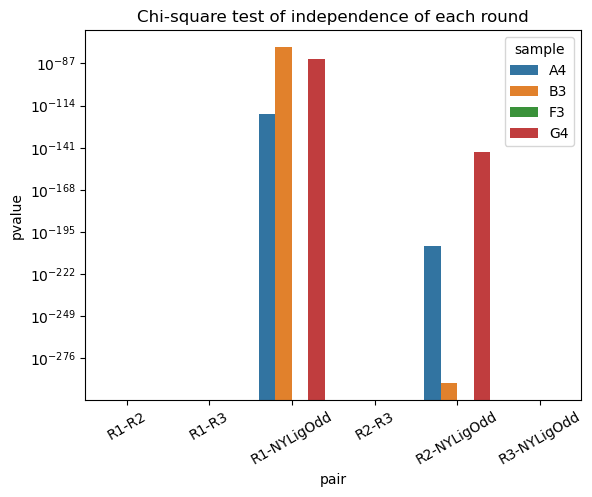

In [159]:
ax = sns.barplot(
    df_rounds_independence.assign(pair=df_rounds_independence['r1'].str.cat(df_rounds_independence['r2'], sep='-')),
    x='pair',
    y='pvalue',
    hue='sample')
ax.set_yscale('log')
ax.tick_params(axis='x', labelrotation=30)
ax.set_title('Chi-square test of independence of each round')
ax.figure.show()

# Analyze barcode count distributions

Structure of `dist_oligos` and `dist_unique_oligos` dictionaries
- key: sample
- value: pandas.Series of barcode counts

In [109]:
dist_oligos = {}
dist_unique_oligos = {}
for sample, sample_data in sample_barcode_counts.items():
    dist_oligos[sample] = pd.Series(sum(barcode_data.values()) for barcode_data in sample_data.values())
    dist_unique_oligos[sample] = pd.Series(map(len, sample_data.values()))

In [110]:
for sample, sample_data in sample_barcode_counts.items():
    print(f'Number of barcodes in sample {sample}:', len(sample_data))
    print('Frequency of most common barcodes:', dist_oligos[sample].sort_values(ascending=False).values[:10])
    print('Frequency of most common barcodes (dedup):', dist_unique_oligos[sample].sort_values(ascending=False).values[:10])
    print()

Number of barcodes in sample A4: 53866
Frequency of most common barcodes: [4456 3831 3718 3637 3427 3419 3382 3196 3085 2996]
Frequency of most common barcodes (dedup): [2745 2451 2337 2254 2152 2096 2078 1990 1920 1880]

Number of barcodes in sample B3: 63211
Frequency of most common barcodes: [13312 10602 10575  8658  6146  6096  5382  5354  5340  5291]
Frequency of most common barcodes (dedup): [7363 5882 5721 4887 3431 3421 3128 3056 3044 3007]

Number of barcodes in sample F3: 390681
Frequency of most common barcodes: [285 275 273 271 264 250 248 246 240 233]
Frequency of most common barcodes (dedup): [181 167 162 156 152 146 145 139 136 132]

Number of barcodes in sample G4: 74567
Frequency of most common barcodes: [9977 7884 7712 5268 3792 2971 2846 2677 2660 2521]
Frequency of most common barcodes (dedup): [5964 4682 4516 3278 2312 1818 1730 1678 1630 1567]



In [129]:
df_dist_oligos = pd.concat(
    [
        s.rename("count")
        .to_frame()
        .pipe(
            lambda df: df.assign(
                **dict(sample=sample, proportion=df["count"] / df["count"].sum())
            )
            .sort_values("count", ascending=False)
            .assign(barcode_rank=range(1, len(df) + 1))
        )
        for sample, s in dist_oligos.items()
    ],
    axis=0,
).astype(dict(sample="category"))


df_dist_unique_oligos = pd.concat(
    [
        s.rename("count")
        .to_frame()
        .pipe(
            lambda df: df.assign(
                **dict(sample=sample, proportion=df["count"] / df["count"].sum())
            )
            .sort_values("count", ascending=False)
            .assign(barcode_rank=range(1, len(df) + 1))
        )
        for sample, s in dist_unique_oligos.items()
    ],
    axis=0,
).astype(dict(sample="category"))

### Count (or proportion of total count) per barcode (akin to scSPRITE Figure 1C)

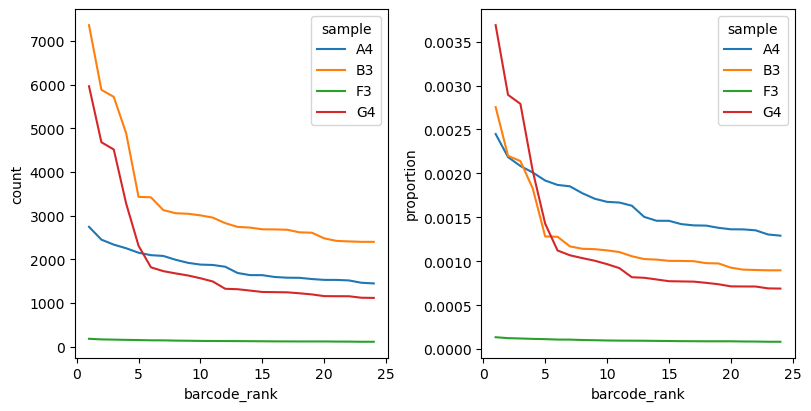

In [133]:
fig, axs = plt.subplots(1, 2, figsize=(8, 4), constrained_layout=True, sharex=True)
sns.lineplot(
    df_dist_unique_oligos.loc[df_dist_unique_oligos['barcode_rank'] < 25],
    x='barcode_rank',
    y='count',
    hue='sample',
    ax=axs[0])
sns.lineplot(
    df_dist_unique_oligos.loc[df_dist_unique_oligos['barcode_rank'] < 25],
    x='barcode_rank',
    y='proportion',
    hue='sample',
    ax=axs[1])
fig.savefig(
    os.path.join(DIR_RESULTS, 'barcode_count_by_barcode_rank.png'),
    dpi=300,
    bbox_inches='tight')